In [11]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, Markdown

import sys, os
sys.path.insert(0, '../py_scripts')

import numpy as np
import scipy as sp
import pandas as pd
import numpy.linalg as la
import numpy.random as rand
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as stats


import time
import pickle


import noise_models as noise
import model_fitting as fit
import fig_plot as fplot
import thermo_models as thermo



sns.set(context='talk', font_scale=1.0, color_codes=True, palette='deep', style='ticks', 
        rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in',
            'axes.linewidth': 1.5, 'figure.dpi':100, 'text.usetex':False})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

In [12]:
seed = 42

print("Seed:", seed)

rand.seed(seed)


# name of dataset folder
# label = "21_10_15_highgating"
label = "21_10_15_medhighgating"
# label = "22_01_20"


components = ["phospho", "substrate", "kinase", 'pptase', 'kinase2', 'kinase2phospho']


df_dataset_key = pd.read_csv("../data/"+label+"/dataset_key.csv", sep='\s*,\s*', engine='python').set_index("exp_name")
display(df_dataset_key)

df_MOCU_key = pd.read_csv("../data/"+label+"/MOCU_key.csv", sep='\s*,\s*', engine='python').set_index("component")
display(df_MOCU_key)


# load datasets

df_list = []
for exp_name, row in df_dataset_key.iterrows():
    
    df = pd.read_csv("../data/{}/{}.csv".format(label, row['file_name']))     
    df = df.drop("Unnamed: 0", axis=1, errors='ignore').sample(frac=1.0, replace=True, random_state=seed).reset_index(drop=True)

    df = df.rename(columns={row['substrate_col']:'substrate_anti_exp', 
                         row['phospho_col']:'phospho_anti_exp', 
                         row['kinase_col']:'kinase_anti_exp'})
    
    if row['model'] == 'pushpull' or row['model'] == 'two_layer':
        df = df.rename(columns={row['pptase_col']:'pptase_anti_exp'})
    else:
        df['pptase_anti_exp'] = 1e-8
        
    
    if row['model'] == 'two_layer':
        df = df.rename(columns={row['kinase2_col']:'kinase2_anti_exp'})
        df = df.rename(columns={row['kinase2phospho_col']:'kinase2phospho_anti_exp'})
    else:
        df['kinase2_anti_exp'] = 1e-8
        df['kinase2phospho_anti_exp'] = 1e-8
        
   
    
    df['exp_name'] = exp_name
    df.index.rename('cell_index', inplace=True)
    df_list.append(df)
    
# dataframe containing all datasets   
df_data = pd.concat(df_list) #.drop("Unnamed: 0", axis=1, errors='ignore')
df_data = df_data.reset_index().set_index(['cell_index', 'exp_name'])
df_data = df_data.reorder_levels(df_data.index.names[::-1])

print(len(df_data.index))
df_data.dropna(inplace=True)
print(len(df_data.index))
df_data = df_data[(df_data[df_data.columns] > 0.0).all(axis=1)]
print(len(df_data.index))


# setup noise model dictionary
noise_models = {c:dict() for c in components}
print(noise_models)


display(df_data)

Seed: 42


file_name           model kinase_variant  \
exp_name                                                                
substrate_only                     127  substrate_only            NaN   
non-pplatable                      174   non-pplatable            174   
kinase_dead                        421            push    kinase_dead   
kinase_non-binding                RR+A            push      kinase_wt   
kinase_variant_375                 375            push            375   
kinase_variant_419                 419            push            419   
kinase_zipper_E+A                  E+A            push      kinase_wt   
kinase_zipper_E+E                  E+E            push      kinase_wt   
kinase_zipper_L+A                  L+A            push      kinase_wt   
pptase_dead                pptase dead        pushpull      kinase_wt   
pptase_non-binding  non-binding pptase        pushpull      kinase_wt   
pptase                     with pptase        pushpull      kinase_wt   
two_layer                    two_layer       two_layer      kinase_wt   

                         kinase_zipper pptase_variant       pptase_zipper  \
exp_name                                                                    
substrate_only                     NaN            NaN                 NaN   
non-pplatable                      L+A            NaN                 NaN   
kinase_dead                        L+A            NaN                 NaN   
kinase_non-binding  kinase_non-binding            NaN                 NaN   
kinase_variant_375                 L+A            NaN                 NaN   
kinase_variant_419                 L+A            NaN                 NaN   
kinase_zipper_E+A                  E+A            NaN                 NaN   
kinase_zipper_E+E                  E+E            NaN                 NaN   
kinase_zipper_L+A                  L+A            NaN                 NaN   
pptase_dead                        L+A    pptase_dead                 L+A   
pptase_non-binding                 L+A      pptase_wt  pptase_non-binding   
pptase                             L+A      pptase_wt                 L+A   
two_layer                          L+A      pptase_wt                 L+A   

                   kinase2_variant  kinase2_zipper substrate_col phospho_col  \
exp_name                                                                       
substrate_only                 NaN             NaN            ST         SpT   
non-pplatable                  NaN             NaN            ST         SpT   
kinase_dead                    NaN             NaN            ST         SpT   
kinase_non-binding             NaN             NaN            ST         SpT   
kinase_variant_375             NaN             NaN            ST         SpT   
kinase_variant_419             NaN             NaN            ST         SpT   
kinase_zipper_E+A              NaN             NaN            ST         SpT   
kinase_zipper_E+E              NaN             NaN            ST         SpT   
kinase_zipper_L+A              NaN             NaN            ST         SpT   
pptase_dead                    NaN             NaN            ST         SpT   
pptase_non-binding             NaN             NaN            ST         SpT   
pptase                         NaN             NaN            ST         SpT   
two_layer               kinase2_wt  kinase2_zipper           ST2        SpT2   

                   kinase_col pptase_col kinase2_col kinase2phospho_col  \
exp_name                                                                  
substrate_only             WT        NaN         NaN                NaN   
non-pplatable              WT        NaN         NaN                NaN   
kinase_dead                WT        NaN         NaN                NaN   
kinase_non-binding         WT        NaN         NaN                NaN   
kinase_variant_375         WT        NaN         NaN                NaN   
kinase_variant_419         WT        NaN         Na

file_name anti_col_name GFP_col_name
component                                                       
empty_substrate       BFP(empty cell)            ST          GFP
empty_phospho         BFP(empty cell)           SpT          GFP
empty_kinase          BFP(empty cell)            WT          GFP
empty_pptase          BFP(empty cell)        pptase          GFP
empty_kinase2         BFP(empty cell)            ST          GFP
empty_kinase2phospho  BFP(empty cell)           SpT          GFP
substrate                 ST:SpT MOCU            ST          GFP
phospho                   ST:SpT MOCU           SpT          GFP
kinase                        WT MOCU            WT          GFP
pptase                    pptase MOCU        pptase          GFP
kinase2                   ST:SpT MOCU            ST          GFP
kinase2phospho            ST:SpT MOCU           SpT          GFP

148135
148135
148135
{'phospho': {}, 'substrate': {}, 'kinase': {}, 'pptase': {}, 'kinase2': {}, 'kinase2phospho': {}}


kinase_anti_exp  substrate_anti_exp  \
exp_name       cell_index                                        
substrate_only 0                 79.178284         2212.525146   
               1                 86.252625         4954.513184   
               2                 10.157516         3487.114746   
               3                 96.854454          253.888428   
               4                118.221375          584.118408   
...                                    ...                 ...   
two_layer      8387             538.831848          509.163879   
               8388             502.579071          645.187561   
               8389             172.194412          680.760376   
               8390             129.300323          687.451172   
               8391             223.427887          396.494293   

                           phospho_anti_exp  pptase_anti_exp  \
exp_name       cell_index                                      
substrate_only 0                 133.354218     1.000000e-08   
               1                 112.124626     1.000000e-08   
               2                 119.673706     1.000000e-08   
               3                 100.082169     1.000000e-08   
               4                  39.466415     1.000000e-08   
...                                     ...              ...   
two_layer      8387              704.758423     7.326640e+01   
               8388             1412.649902     2.589982e+02   
               8389             2112.287354     2.860129e+02   
               8390             1222.891113     5.057090e+02   
               8391              746.775269     8.001365e+01   

                           kinase2_anti_exp  kinase2phospho_anti_exp  
exp_name       cell_index                                             
substrate_only 0               1.000000e-08             1.000000e-08  
               1               1.000000e-08             1.000000e-08  
               2               1.000000e-08             1.000000e-08  
               3               1.000000e-08             1.000000e-08  
               4               1.000000e-08             1.000000e-08  
...                                     ...                      ...  
two_layer      8387            5.938093e+02             1.440575e+03  
               8388            9.887302e+02             2.151519e+03  
               8389            1.987362e+03             1.990649e+03  
               8390            8.492007e+02             1.806211e+03  
               8391            5.518015e+02             1.658656e+03  

[148135 rows x 6 columns]

# Plot raw data for each experiment

In [ ]:
for exp_name, row in df_dataset_key.iterrows():
    
    if row['model'] == 'push' or row['model'] == "substrate_only" or row['model'] == "non-pplatable":
        fplot.plot_push_dataset_summary(df_data, exp_name)
    elif row['model'] == 'pushpull' or row['model'] == 'two_layer':
        fplot.plot_pushpull_dataset_summary(df_data, exp_name)
                

    

# Load noise model data and construct probability density functions

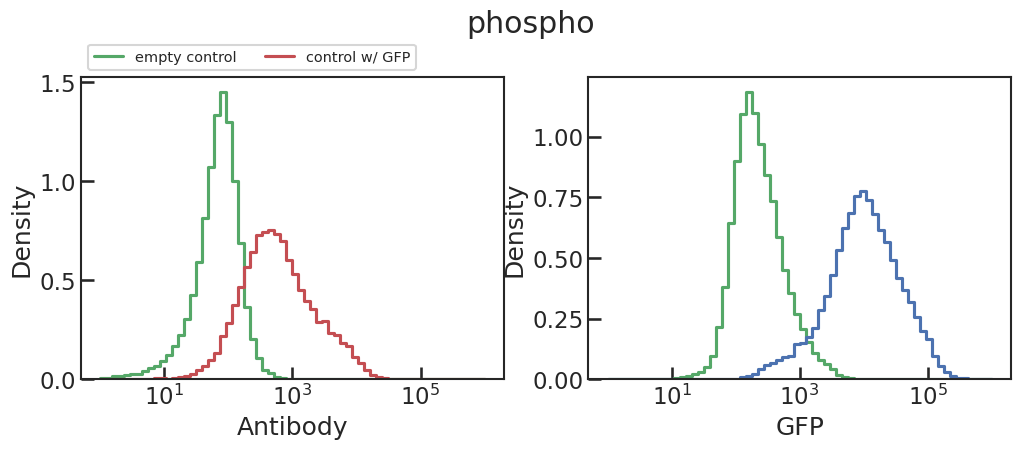

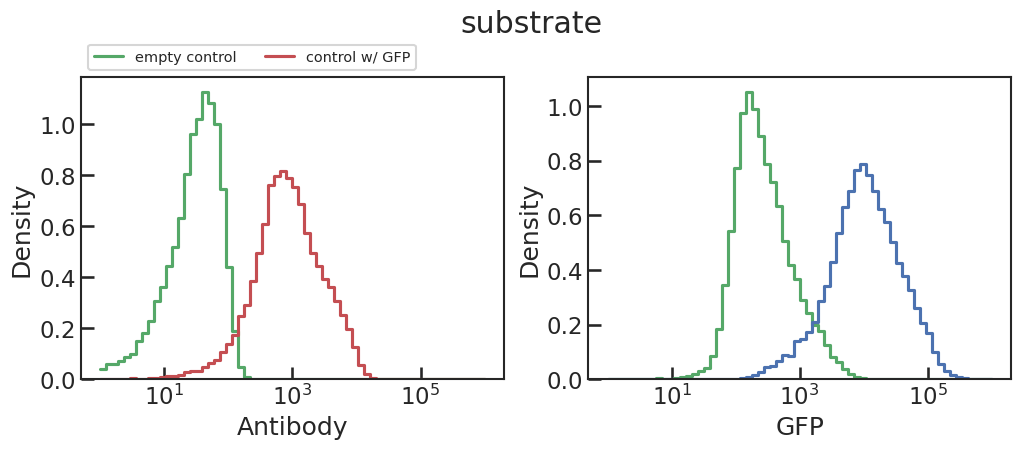

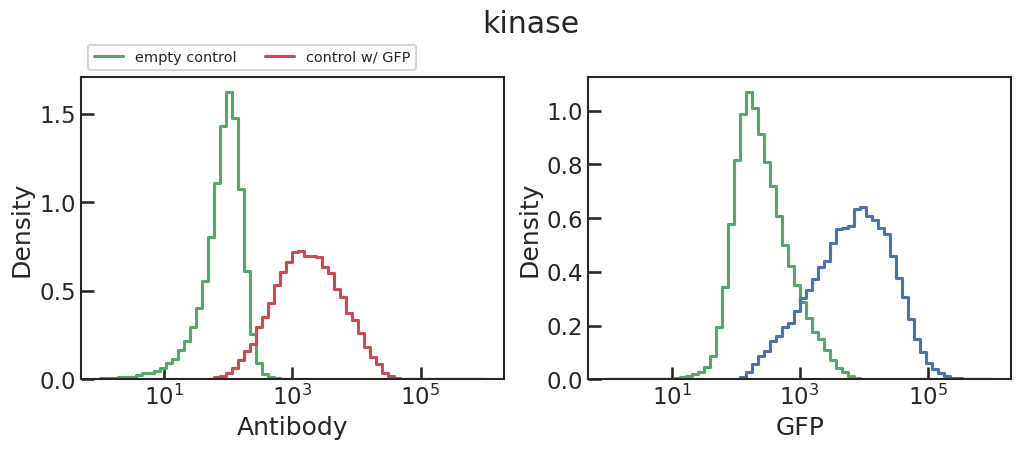

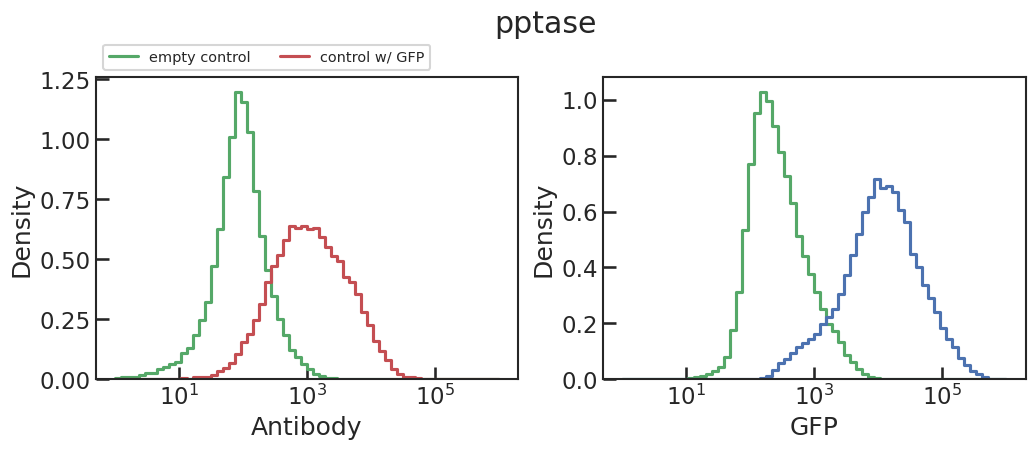

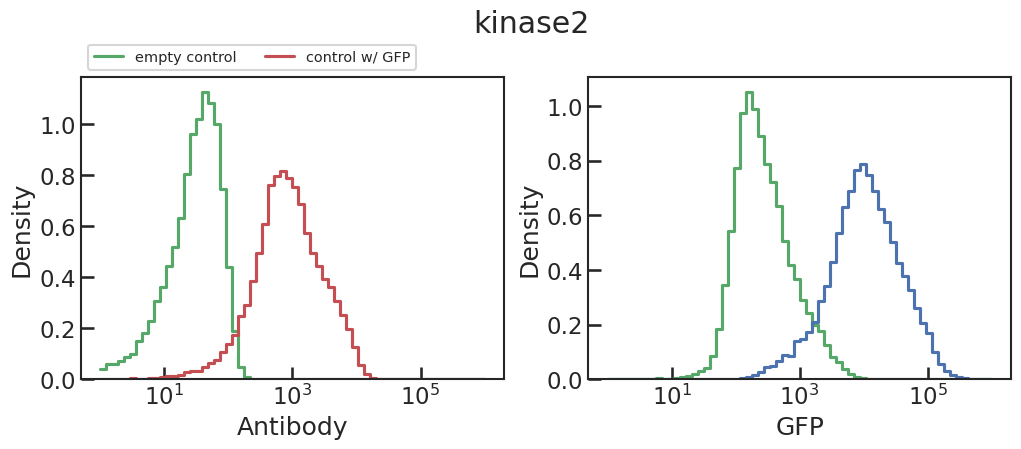

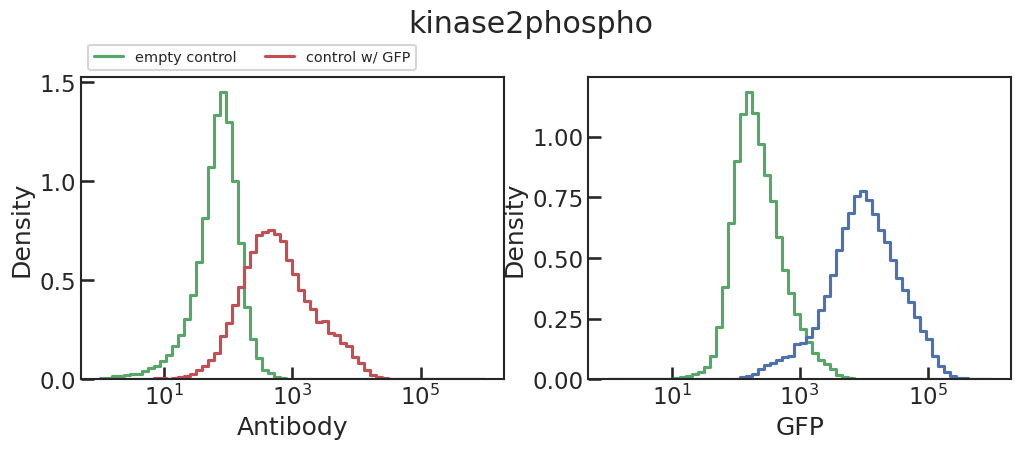

In [13]:
# points per bin
ppbin = 100

for c in components:
    
    # distribution of antibody values w GFP and GFP for non-empty cells
    df = pd.read_csv("../data/{}/{}.csv".format(label, df_MOCU_key.loc[c, 'file_name']))    
    anti = df[df_MOCU_key.loc[c, 'anti_col_name']].values
    GFP = df[df_MOCU_key.loc[c, 'GFP_col_name']].values
    idx = (anti > 0.0) & (GFP > 0.0)
    noise_models[c]['anti'] = noise.Density(anti[idx], ppbin=ppbin)
    noise_models[c]['GFP'] = noise.Density(GFP[idx], ppbin=ppbin)
    
    # distribution of antibodies and GFP for empty cells
    df = pd.read_csv("../data/{}/{}.csv".format(label, df_MOCU_key.loc['empty_'+c, 'file_name']))
    anti = df[df_MOCU_key.loc['empty_'+c, 'anti_col_name']].values
    GFP = df[df_MOCU_key.loc['empty_'+c, 'GFP_col_name']].values
    idx = (anti > 0.0) & (GFP > 0.0)
    noise_models[c]['empty_anti'] = noise.Density(anti[idx], ppbin=ppbin)
    noise_models[c]['empty_GFP'] = noise.Density(GFP[idx], ppbin=ppbin)
    
    
    binrange = (0, 6)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), squeeze=False)
    
    fig.suptitle(c, y=1.05)

    ax = axes[0, 0]
    
    sns.histplot(noise_models[c]['empty_anti'].df['vals'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', element='step', fill=False, color='g', stat='density')
    sns.histplot(noise_models[c]['anti'].df['vals'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='control w/ GFP', element='step', fill=False, color='r', stat='density')
  


    ax.set_xscale('log')
    ax.set_xlabel("Antibody")

    
    ax.legend(loc='lower left', fontsize='xx-small', bbox_to_anchor=(0.0, 1.0), ncol=3)


    ax = axes[0, 1]

    sns.histplot(noise_models[c]['empty_GFP'].df['vals'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', element='step', fill=False, color='g', stat='density')
    sns.histplot(noise_models[c]['GFP'].df['vals'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='control', element='step', fill=False, color='b', stat='density')

    ax.set_xscale('log')
    ax.set_xlabel("GFP")


    plt.show()
    
    

# Noise models for converting antibody measurements to MOCU (GFP units)

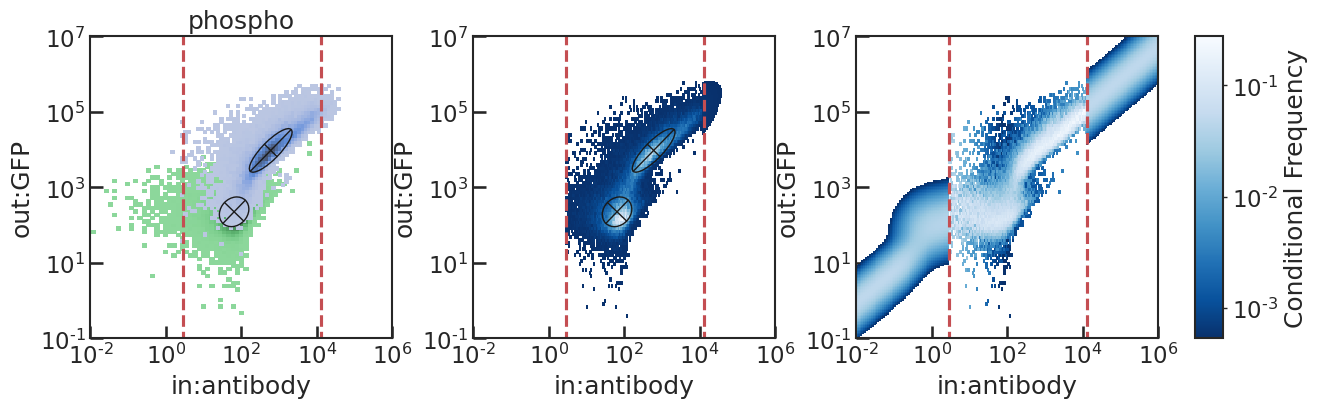

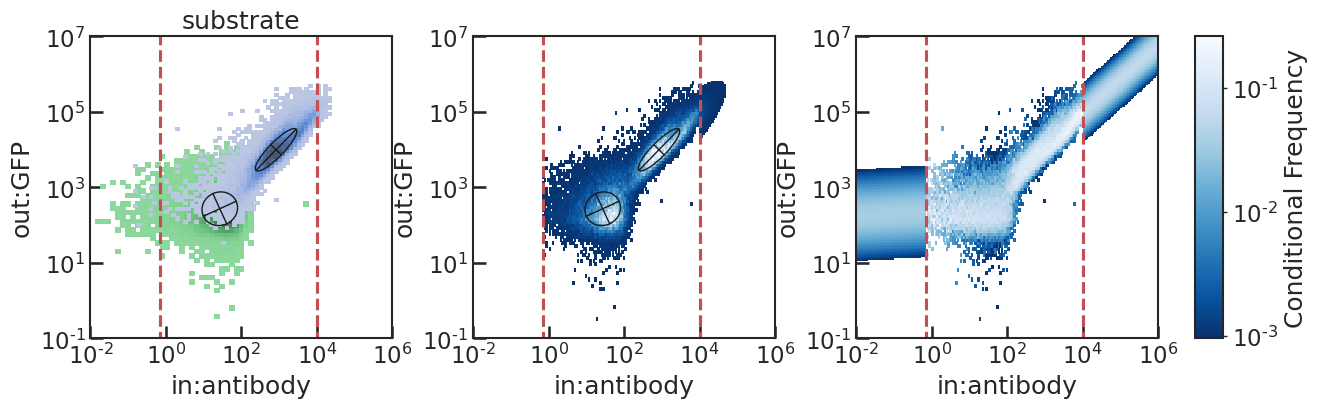

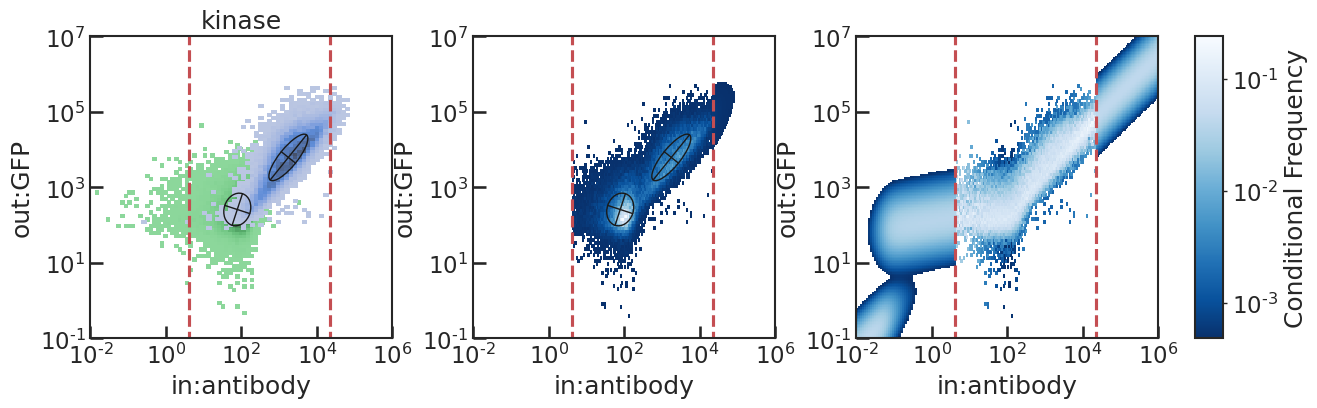

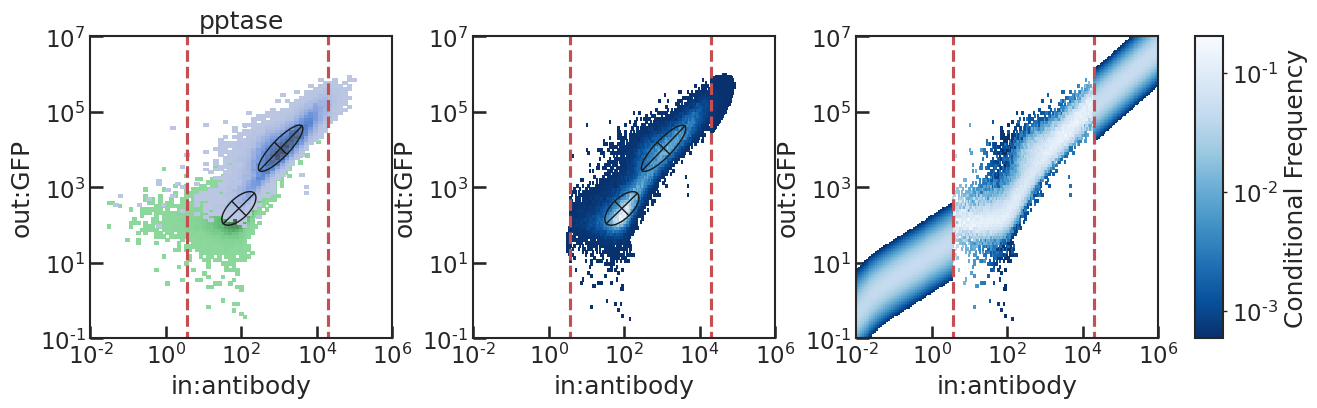

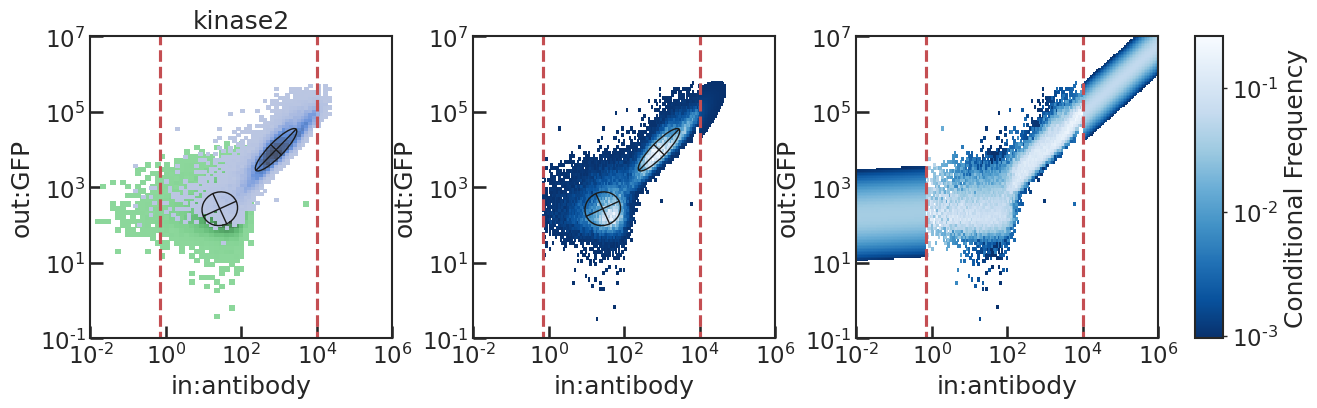

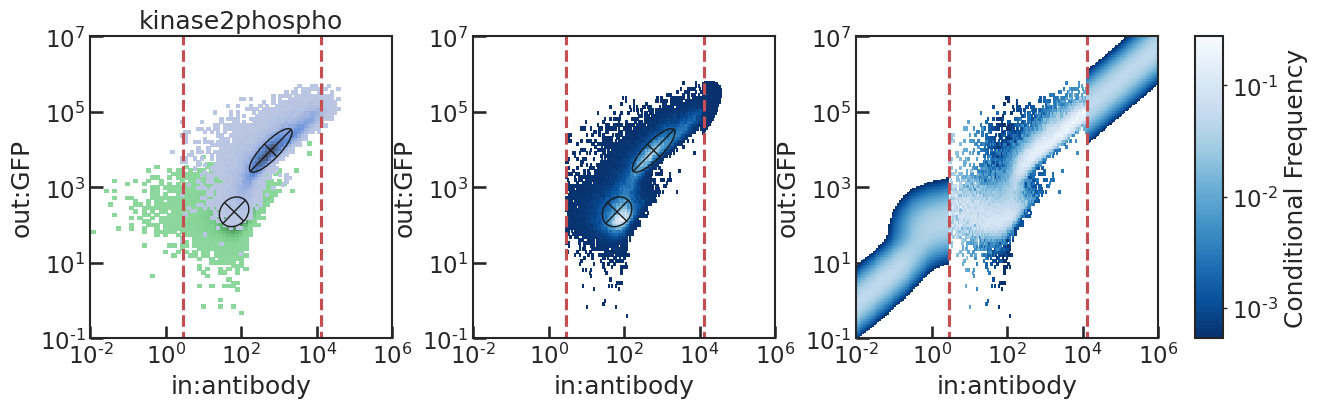

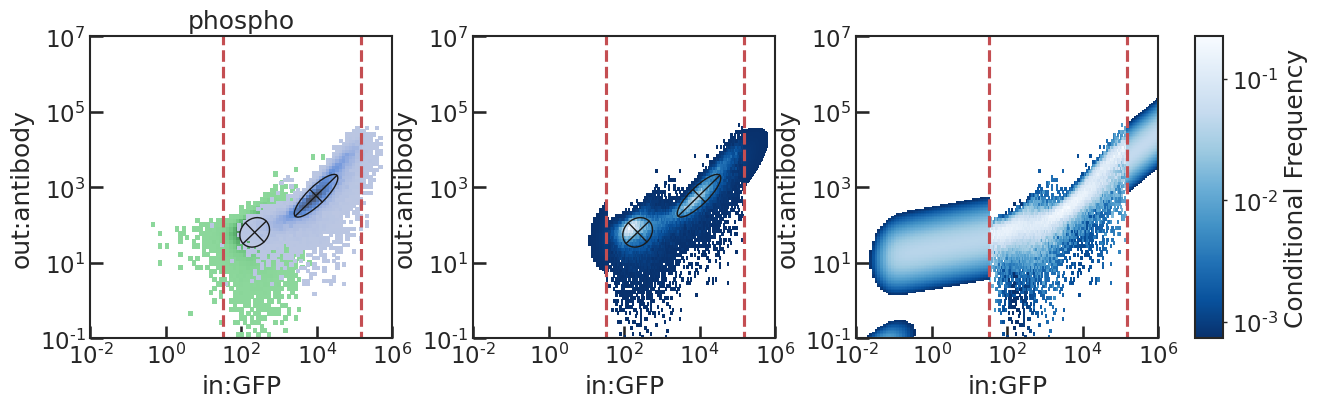

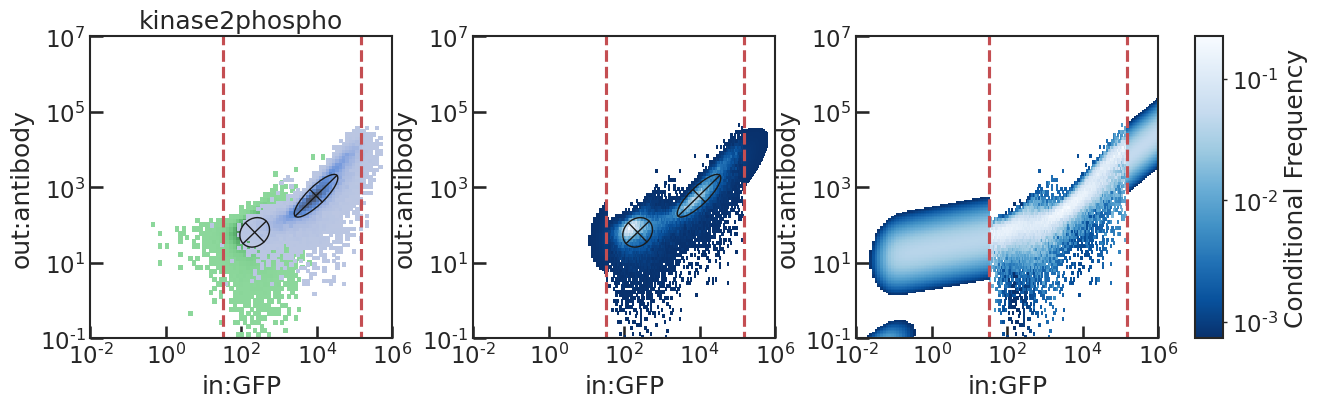

In [14]:
# points per bin
ppbin = 10

gaussian_cutoff_percentile = 0.99
empty_prior = 0.5

for c in components:
        
    noise_models[c]['empty_anti2GFP'] =  noise.RandomConditionalNoise(noise_models[c]['empty_anti'].get_data(), 
                                            noise_models[c]['empty_GFP'].get_data(), ppbin=ppbin)

    noise_models[c]['nonempty_anti2GFP'] =  noise.RandomConditionalNoise(noise_models[c]['anti'].get_data(), 
                                            noise_models[c]['GFP'].get_data(), ppbin=ppbin)
        
        
    noise_models[c]['composite_anti2GFP'] = noise.CompositeConditionalNoise(noise_models[c]['empty_anti2GFP'], 
                                                                            noise_models[c]['nonempty_anti2GFP'],
                                                                           empty_prob=empty_prior, 
                                                                            cutoff_percent=gaussian_cutoff_percentile)
    
    fig = plt.figure(figsize=(14, 4))
    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2, sharex=ax1, sharey=ax1) 
    ax3 = fig.add_subplot(1, 3, 3, sharex=ax1, sharey=ax1)
    
    ax = ax1
        
    noise_models[c]['composite_anti2GFP'].plot(ax)
    ax.set_title(c)

    
    ax.set_ylabel('out:GFP')
    ax.set_xlabel('in:antibody')
    
    ax.set_aspect('equal')
    
    
    ax = ax2
    
    noise_models[c]['composite_anti2GFP'].plot_composite(ax)

    ax.set_ylabel('out:GFP')
    ax.set_xlabel('in:antibody')

    ax.set_aspect('equal')
    
    ax = ax3
    
    noise_models[c]['composite_anti2GFP'].plot_conditional_prob(ax, cbar=True)
    
    ax.set_ylabel('out:GFP')
    ax.set_xlabel('in:antibody')

    ax.set_aspect('equal')
    

    plt.show()
    
        
# reverse noise model for pplated substrate

c = 'phospho'

noise_models[c]['empty_GFP2anti'] =  noise.RandomConditionalNoise(noise_models[c]['empty_GFP'].get_data(), 
                                            noise_models[c]['empty_anti'].get_data(), ppbin=ppbin)

noise_models[c]['nonempty_GFP2anti'] =  noise.RandomConditionalNoise(noise_models[c]['GFP'].get_data(), 
                                        noise_models[c]['anti'].get_data(), ppbin=ppbin)

noise_models[c]['composite_GFP2anti'] = noise.CompositeConditionalNoise(noise_models[c]['empty_GFP2anti'], 
                                                                        noise_models[c]['nonempty_GFP2anti'],
                                                                       empty_prob=empty_prior, 
                                                                        cutoff_percent=gaussian_cutoff_percentile)

fig = plt.figure(figsize=(14, 4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2, sharex=ax1, sharey=ax1) 
ax3 = fig.add_subplot(1, 3, 3, sharex=ax1, sharey=ax1)

ax = ax1

noise_models[c]['composite_GFP2anti'].plot(ax)
ax.set_title(c)

ax.set_ylabel('out:antibody')
ax.set_xlabel('in:GFP')


ax.set_aspect('equal')


ax = ax2

noise_models[c]['composite_GFP2anti'].plot_composite(ax)

ax.set_ylabel('out:antibody')
ax.set_xlabel('in:GFP')

ax.set_aspect('equal')

ax = ax3

noise_models[c]['composite_GFP2anti'].plot_conditional_prob(ax, cbar=True)

ax.set_ylabel('out:antibody')
ax.set_xlabel('in:GFP')

ax.set_aspect('equal')
    

plt.show()



# reverse noise model for pplated substrate

c = 'kinase2phospho'

noise_models[c]['empty_GFP2anti'] =  noise.RandomConditionalNoise(noise_models[c]['empty_GFP'].get_data(), 
                                            noise_models[c]['empty_anti'].get_data(), ppbin=ppbin)

noise_models[c]['nonempty_GFP2anti'] =  noise.RandomConditionalNoise(noise_models[c]['GFP'].get_data(), 
                                        noise_models[c]['anti'].get_data(), ppbin=ppbin)

noise_models[c]['composite_GFP2anti'] = noise.CompositeConditionalNoise(noise_models[c]['empty_GFP2anti'], 
                                                                        noise_models[c]['nonempty_GFP2anti'],
                                                                       empty_prob=empty_prior, 
                                                                        cutoff_percent=gaussian_cutoff_percentile)

fig = plt.figure(figsize=(14, 4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2, sharex=ax1, sharey=ax1) 
ax3 = fig.add_subplot(1, 3, 3, sharex=ax1, sharey=ax1)

ax = ax1

noise_models[c]['composite_GFP2anti'].plot(ax)
ax.set_title(c)

ax.set_ylabel('out:antibody')
ax.set_xlabel('in:GFP')


ax.set_aspect('equal')


ax = ax2

noise_models[c]['composite_GFP2anti'].plot_composite(ax)

ax.set_ylabel('out:antibody')
ax.set_xlabel('in:GFP')

ax.set_aspect('equal')

ax = ax3

noise_models[c]['composite_GFP2anti'].plot_conditional_prob(ax, cbar=True)

ax.set_ylabel('out:antibody')
ax.set_xlabel('in:GFP')

ax.set_aspect('equal')
    

plt.show()



# Transform to MOCU

In [15]:
for c in components:
    df_data[c+'_GFP_infer'] = 0.0
    df_data[c+'_conc_infer'] = 0.0

for exp_name, row in df_dataset_key.iterrows():
    
    print(exp_name)
        
    df_tmp = df_data.query("exp_name==@exp_name").dropna()
    
    for c in components:
        
        # a weird way to check for nans or empty values
        if row[c+'_col'] != row[c+'_col']:
            continue
            
        anti = df_data.loc[df_tmp.index, c+'_anti_exp']
    
        df_data.loc[df_tmp.index, c+'_GFP_infer'] = noise_models[c]['composite_anti2GFP'].transform(anti)
        


display(df_data)

substrate_only
non-pplatable
kinase_dead
kinase_non-binding
kinase_variant_375
kinase_variant_419
kinase_zipper_E+A
kinase_zipper_E+E
kinase_zipper_L+A
pptase_dead
pptase_non-binding
pptase
two_layer


kinase_anti_exp  substrate_anti_exp  \
exp_name       cell_index                                        
substrate_only 0                 79.178284         2212.525146   
               1                 86.252625         4954.513184   
               2                 10.157516         3487.114746   
               3                 96.854454          253.888428   
               4                118.221375          584.118408   
...                                    ...                 ...   
two_layer      8387             538.831848          509.163879   
               8388             502.579071          645.187561   
               8389             172.194412          680.760376   
               8390             129.300323          687.451172   
               8391             223.427887          396.494293   

                           phospho_anti_exp  pptase_anti_exp  \
exp_name       cell_index                                      
substrate_only 0                 133.354218     1.000000e-08   
               1                 112.124626     1.000000e-08   
               2                 119.673706     1.000000e-08   
               3                 100.082169     1.000000e-08   
               4                  39.466415     1.000000e-08   
...                                     ...              ...   
two_layer      8387              704.758423     7.326640e+01   
               8388             1412.649902     2.589982e+02   
               8389             2112.287354     2.860129e+02   
               8390             1222.891113     5.057090e+02   
               8391              746.775269     8.001365e+01   

                           kinase2_anti_exp  kinase2phospho_anti_exp  \
exp_name       cell_index                                              
substrate_only 0               1.000000e-08             1.000000e-08   
               1               1.000000e-08             1.000000e-08   
               2               1.000000e-08             1.000000e-08   
               3               1.000000e-08             1.000000e-08   
               4               1.000000e-08             1.000000e-08   
...                                     ...                      ...   
two_layer      8387            5.938093e+02             1.440575e+03   
               8388            9.887302e+02             2.151519e+03   
               8389            1.987362e+03             1.990649e+03   
               8390            8.492007e+02             1.806211e+03   
               8391            5.518015e+02             1.658656e+03   

                           phospho_GFP_infer  phospho_conc_infer  \
exp_name       cell_index                                          
substrate_only 0                  975.604414                 0.0   
               1                 1749.659563                 0.0   
               2                  336.290265                 0.0   
               3                   83.811712                 0.0   
               4                  310.791469                 0.0   
...                                      ...                 ...   
two_layer      8387              4883.559992                 0.0   
               8388             29577.775821                 0.0   
               8389             14195.129606                 0.0   
               8390             13589.528204                 0.0   
               8391              9974.198113                 0.0   

                           substrate_GFP_infer  substrate_conc_infer  \
exp_name       cell_index                                              
substrate_only 0                  21241.623933                   0.0   
               1                  35254.937260                   0.0   
               2                  21448.420977                   0.0   
               3                   2265.473029                   0.0   
               4                  11529.644980                   0.0   
...      

# Save Inferred MOCU Values

In [43]:
df_data.to_csv("../data/"+label+"/model_predictions.csv", sep=',')

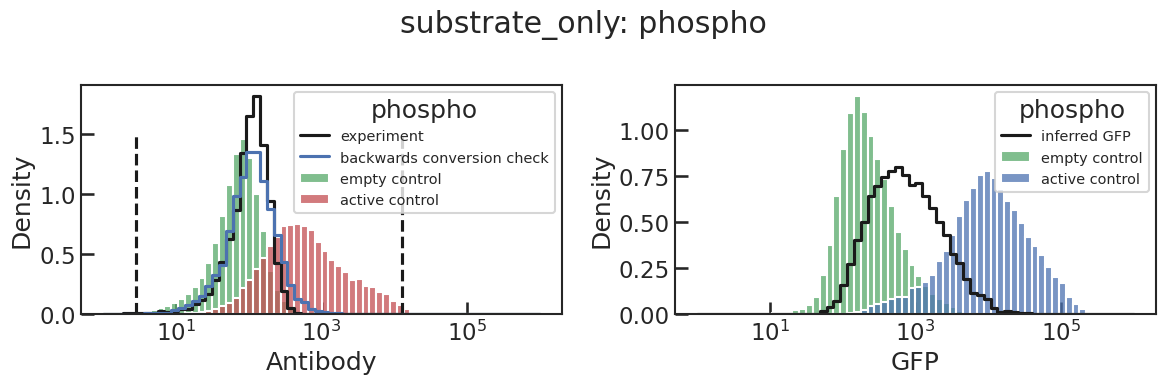

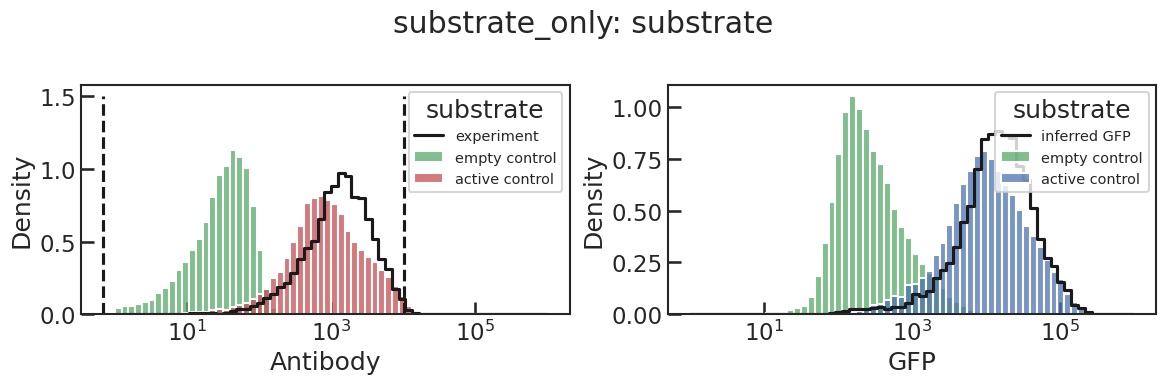

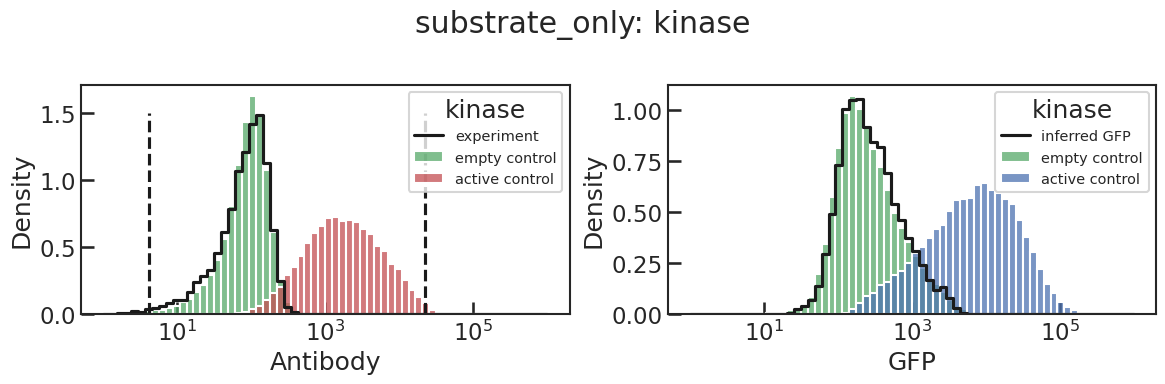

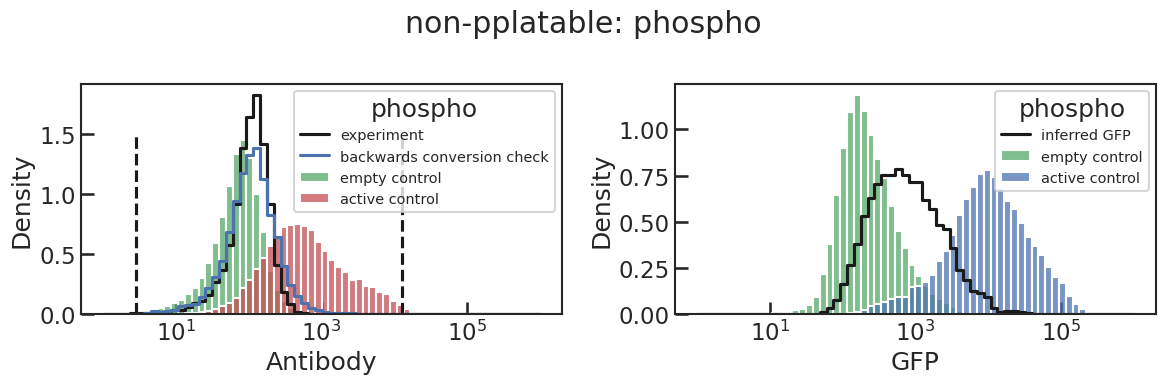

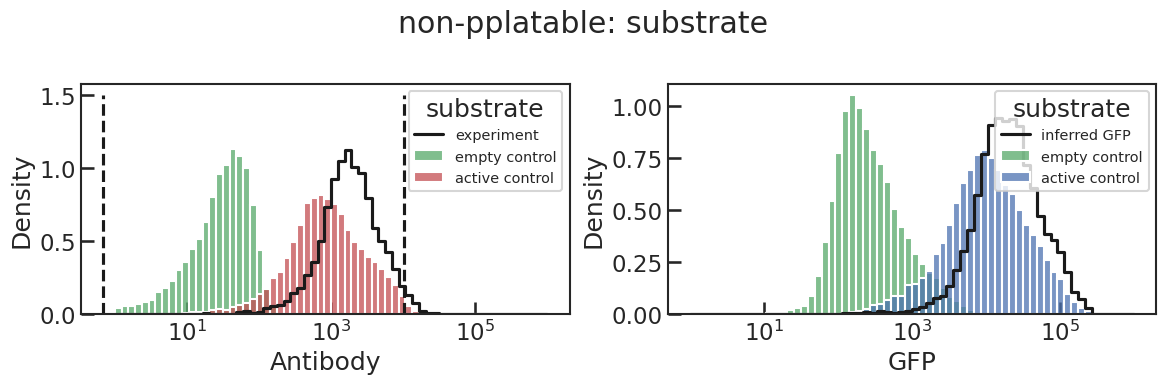

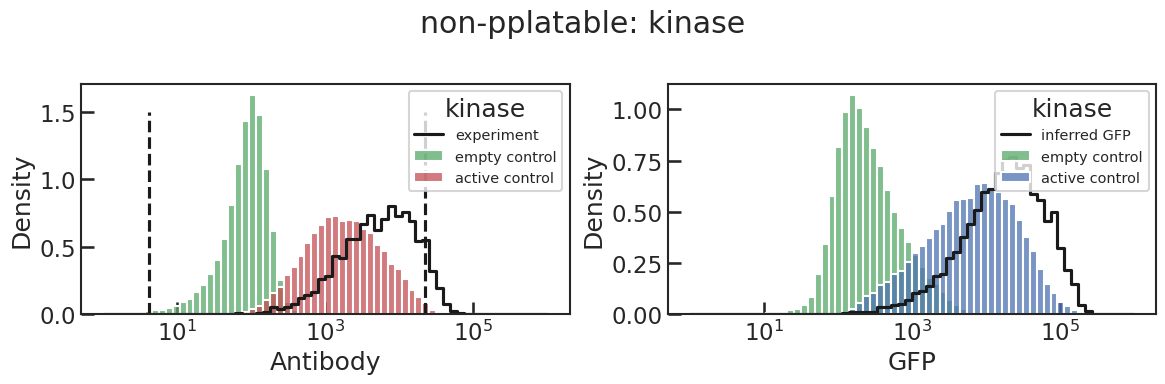

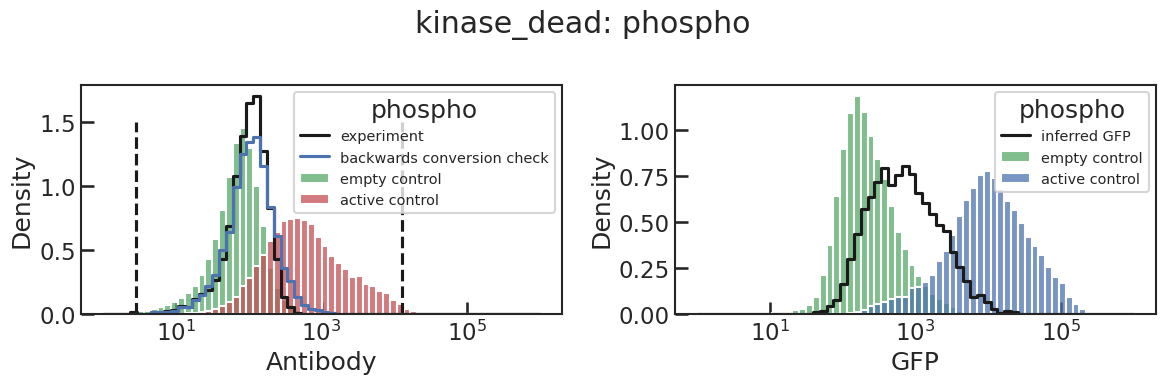

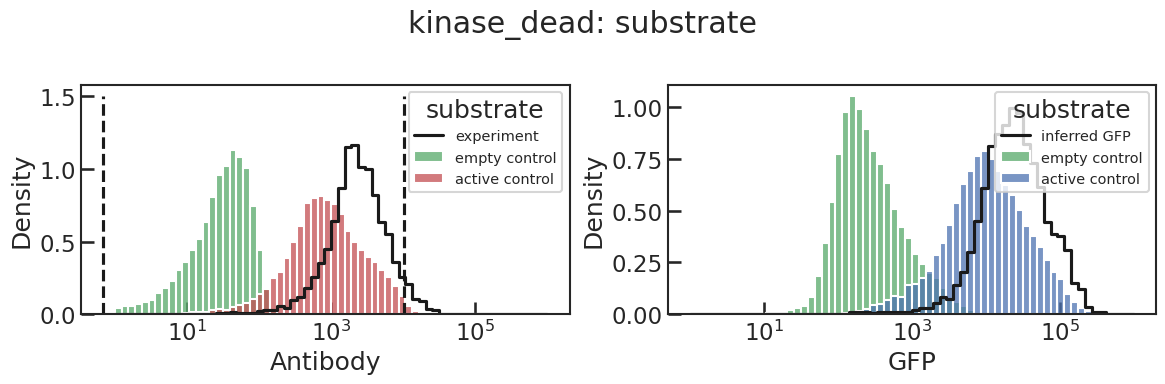

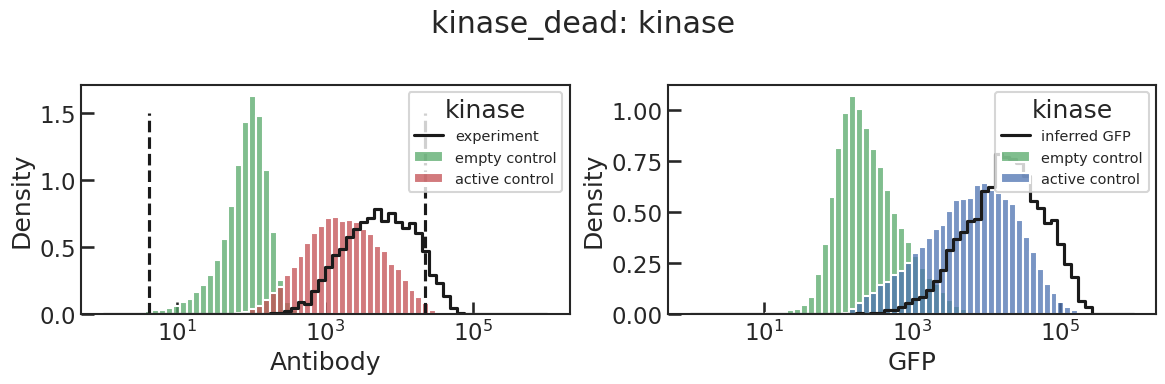

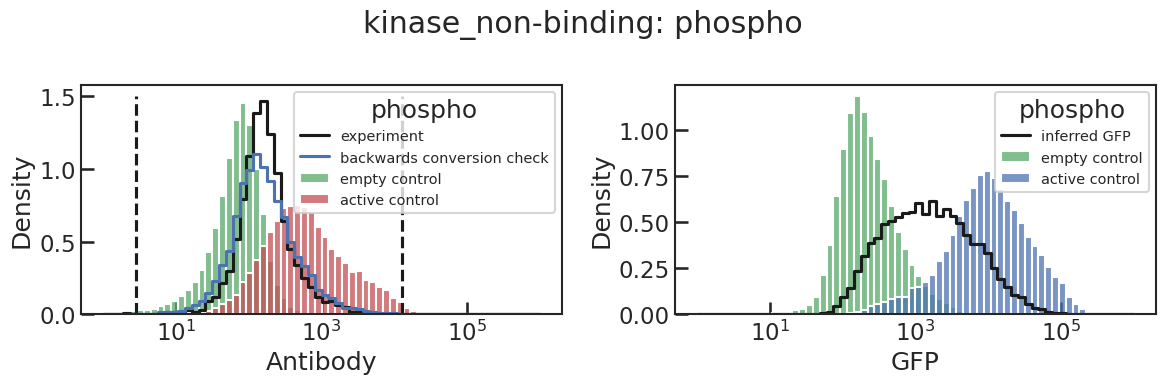

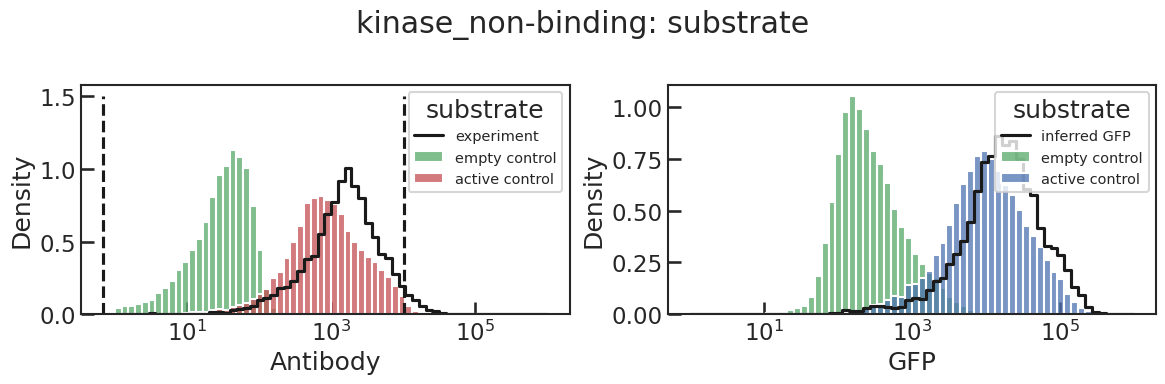

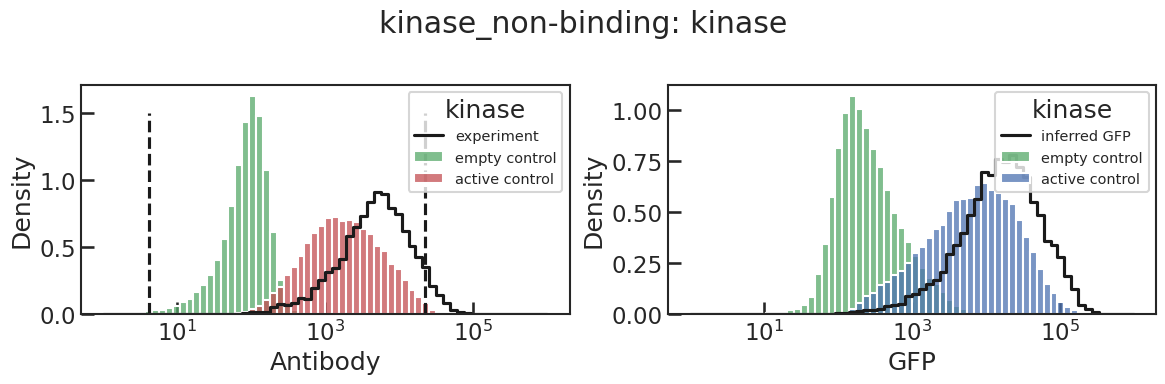

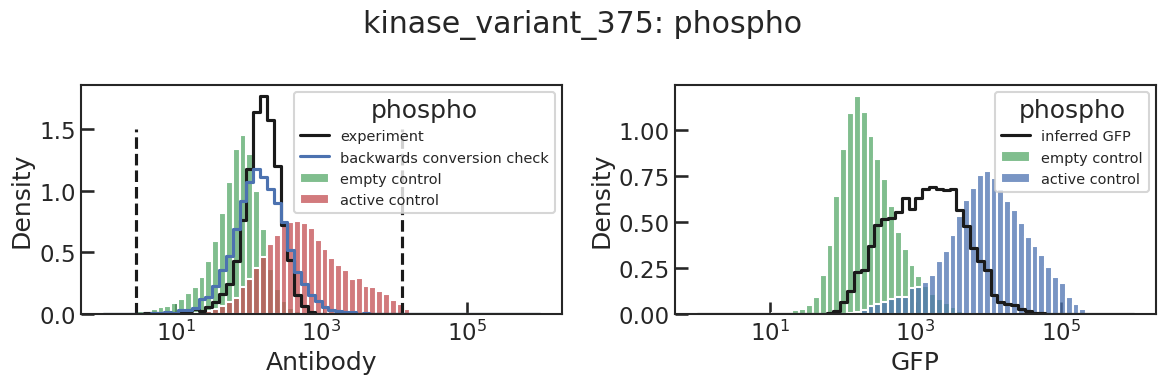

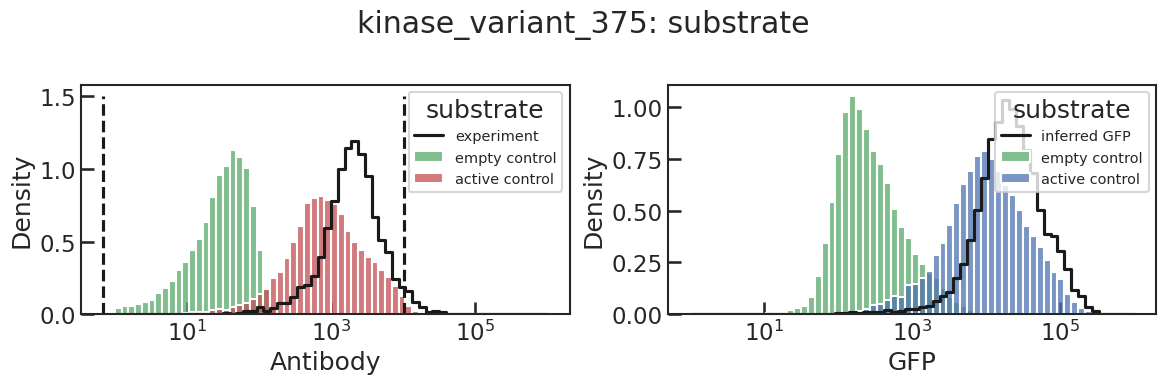

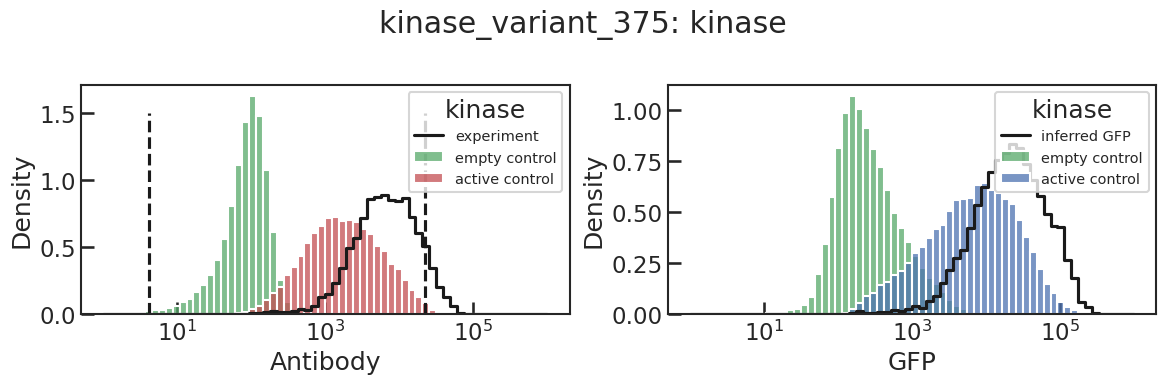

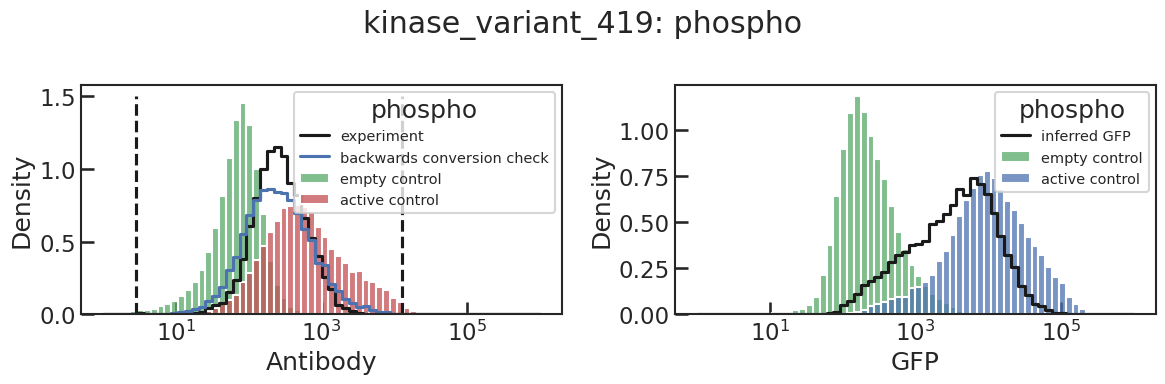

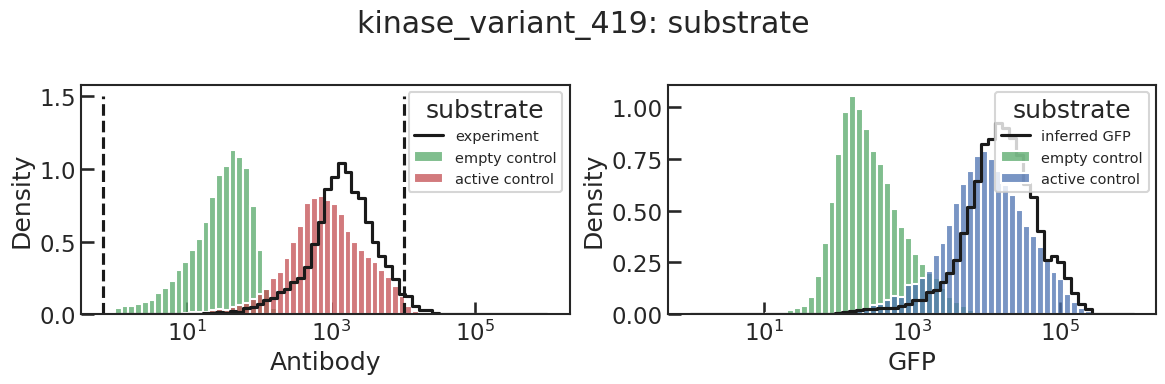

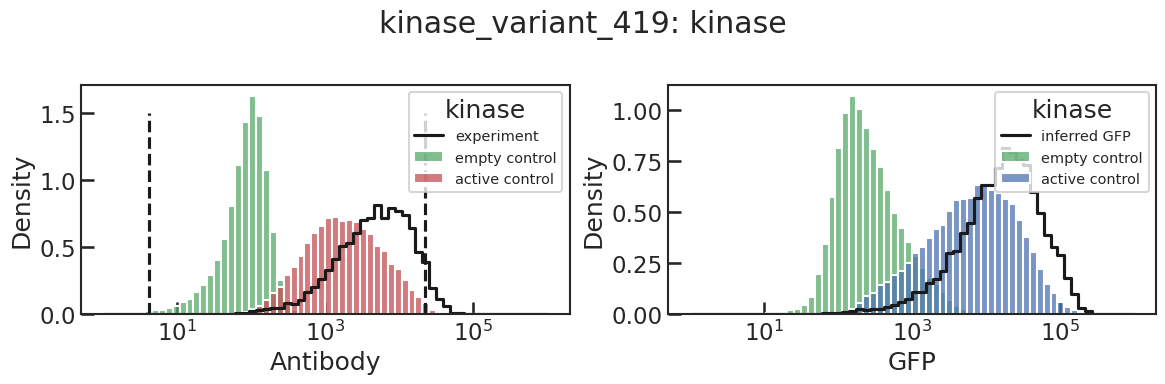

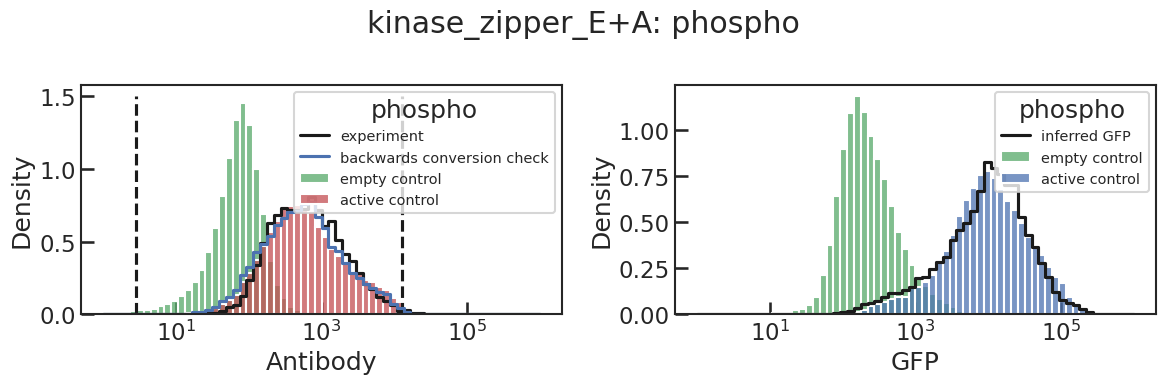

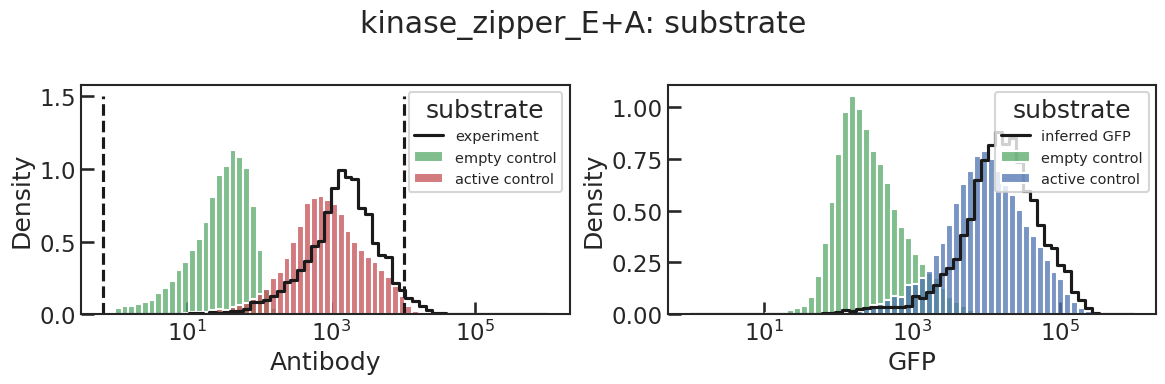

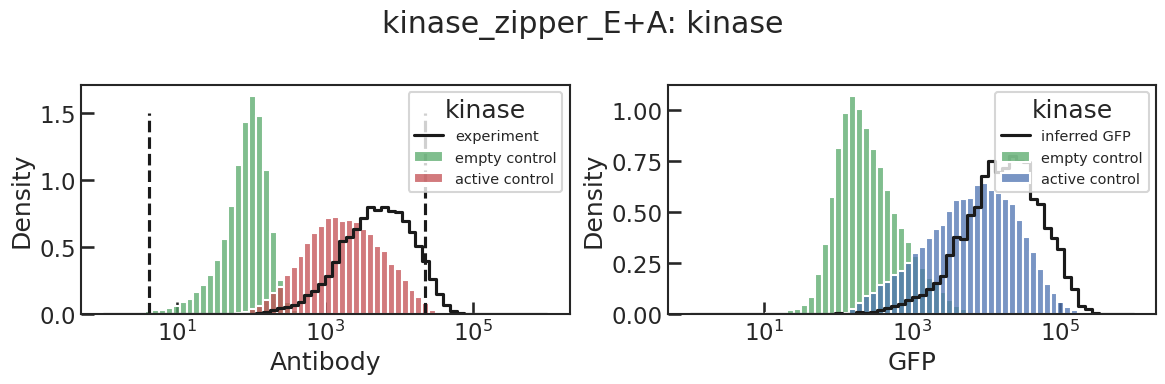

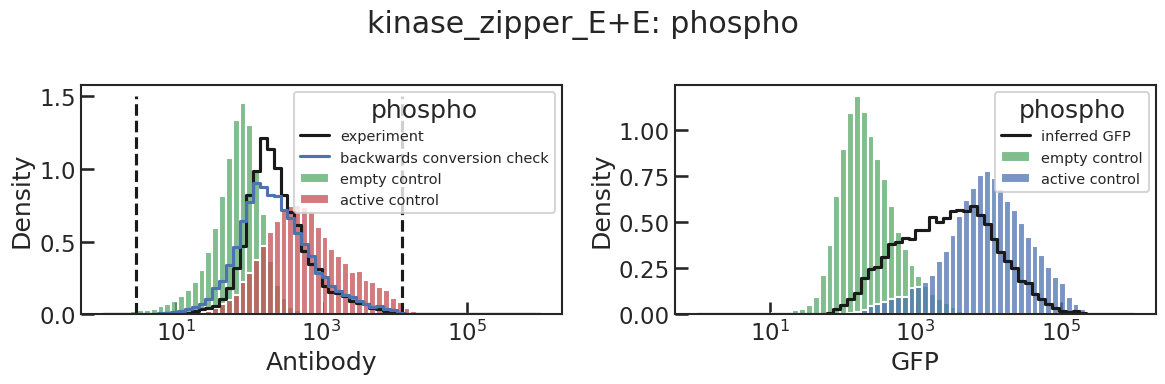

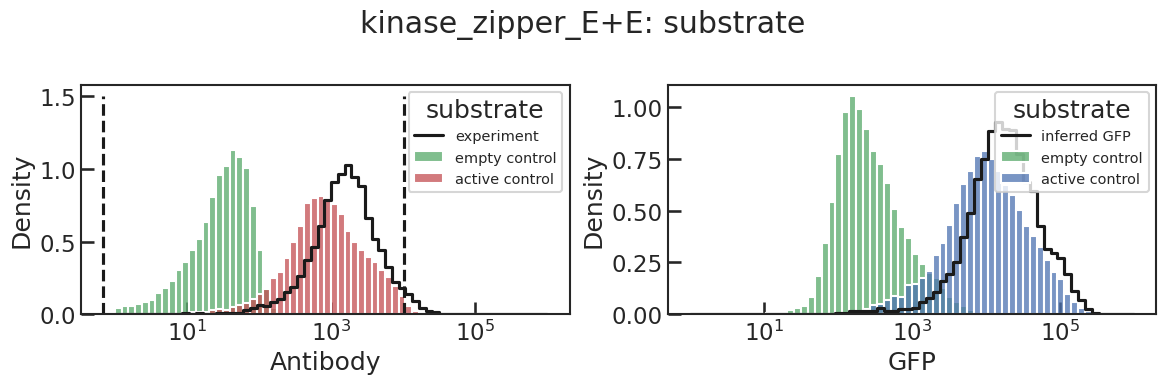

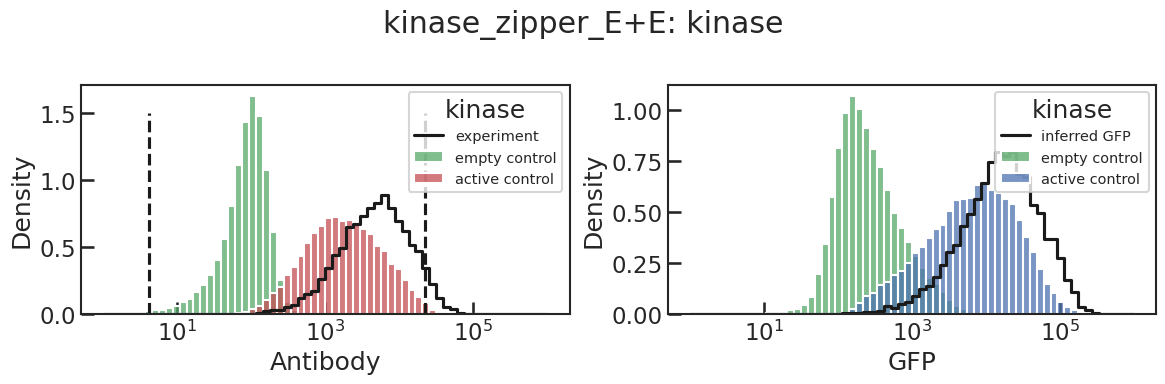

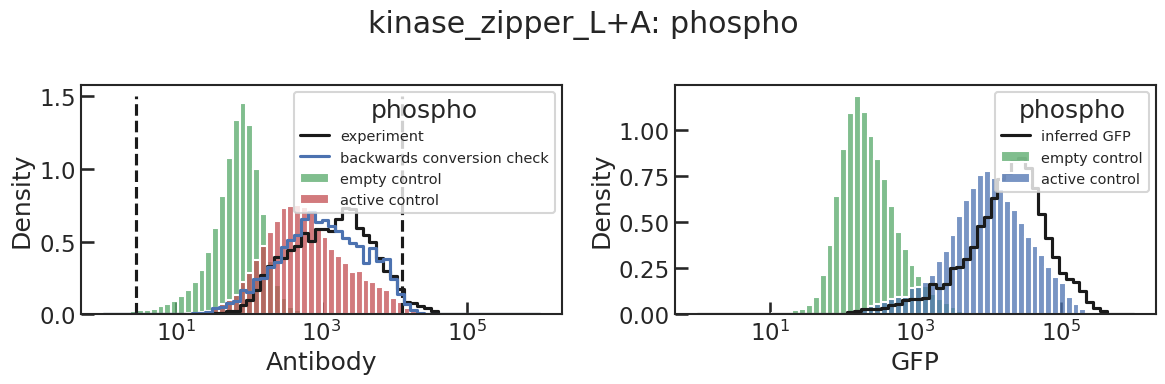

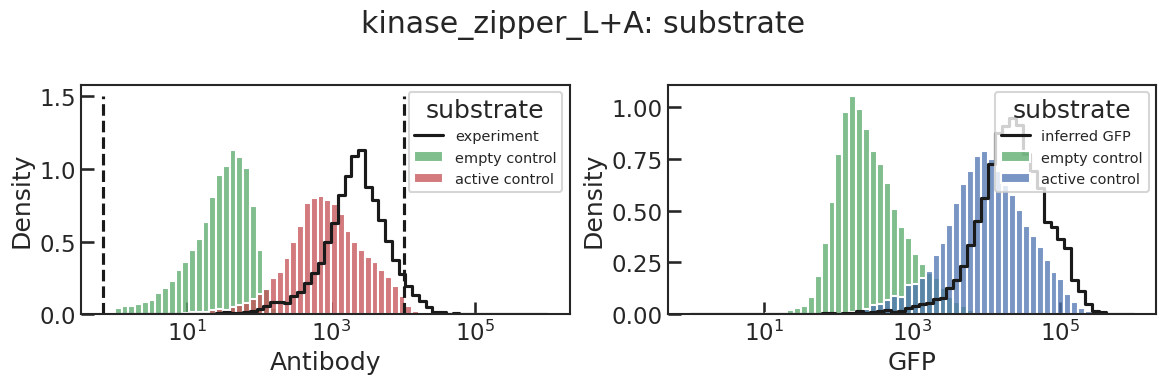

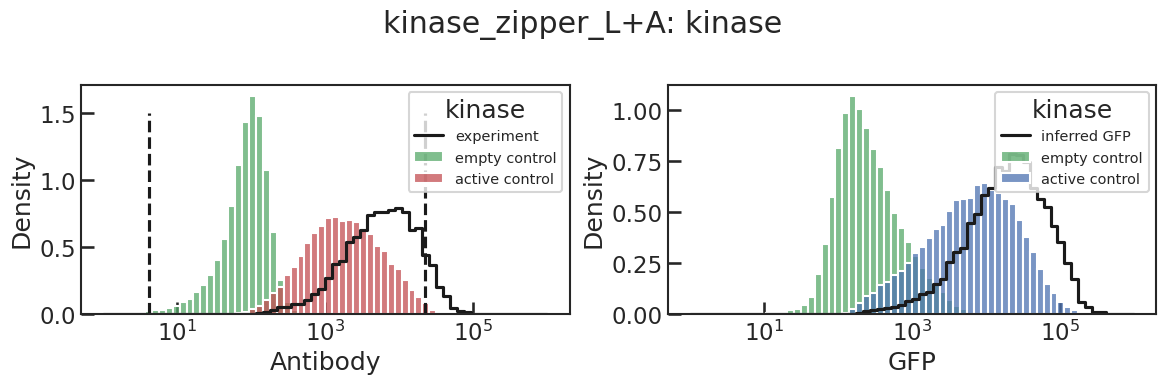

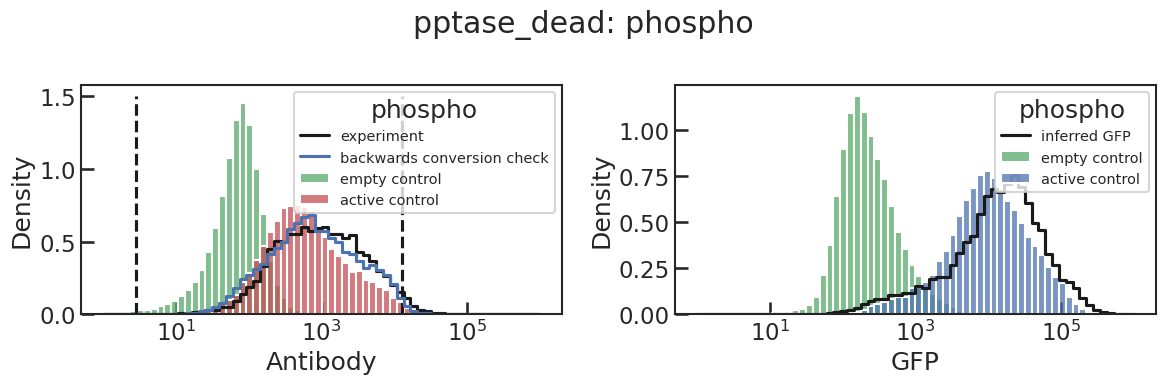

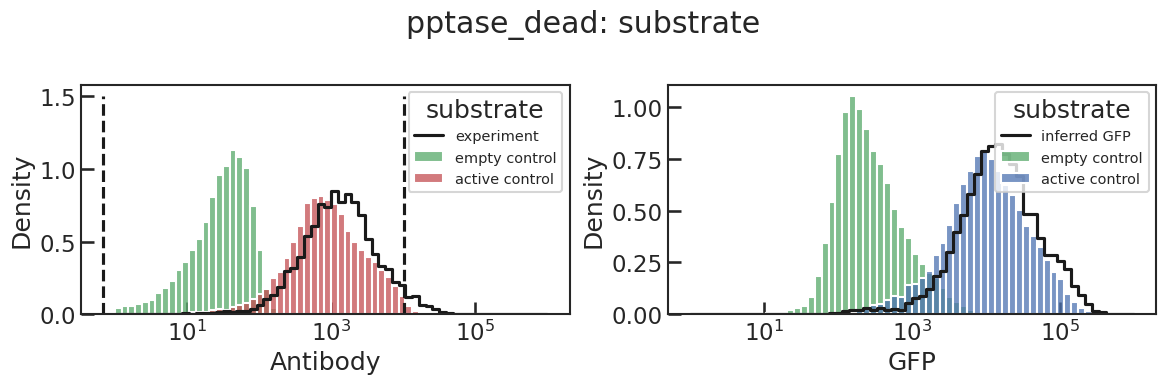

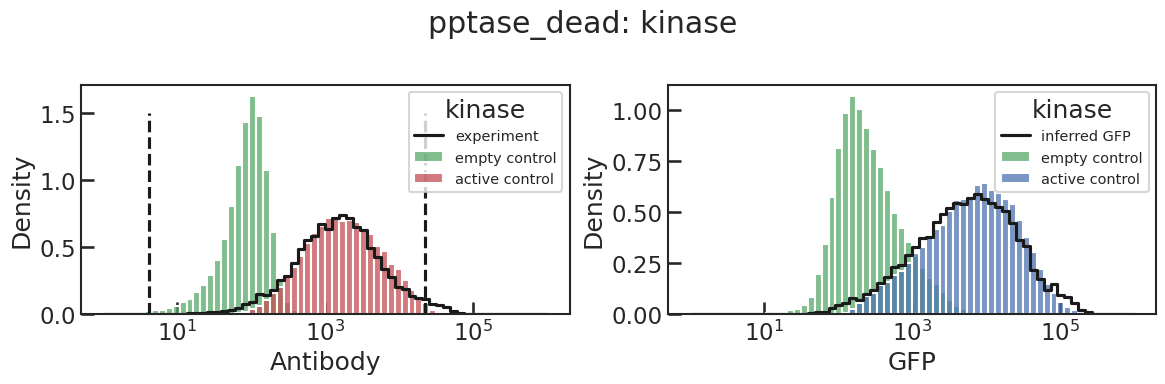

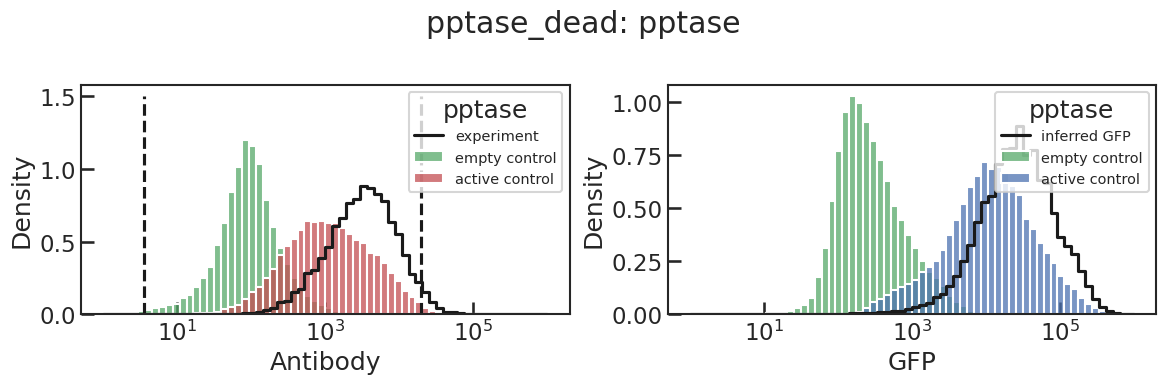

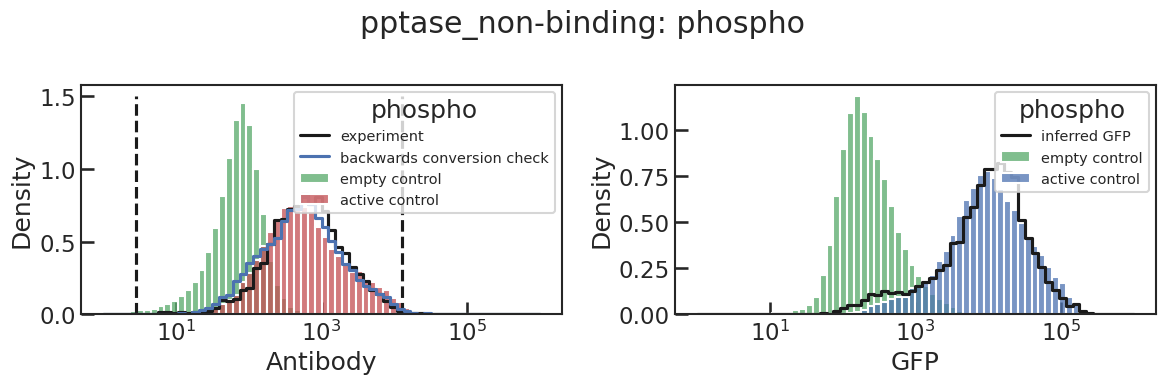

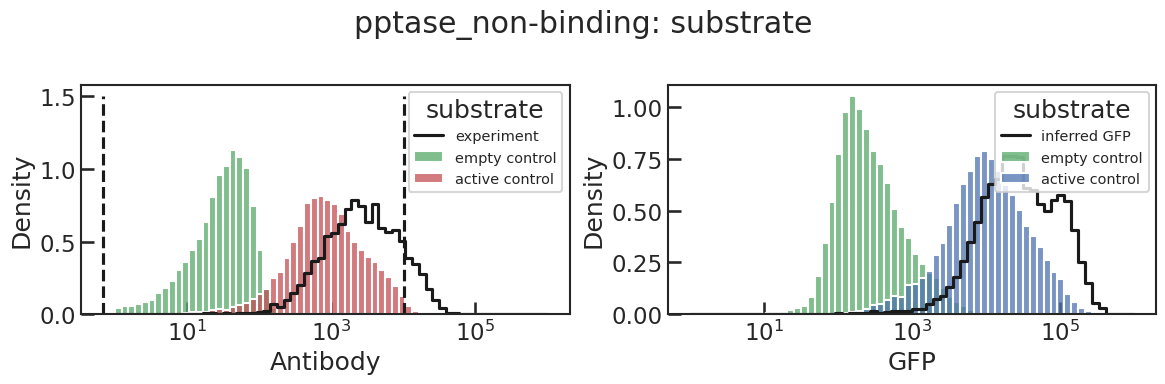

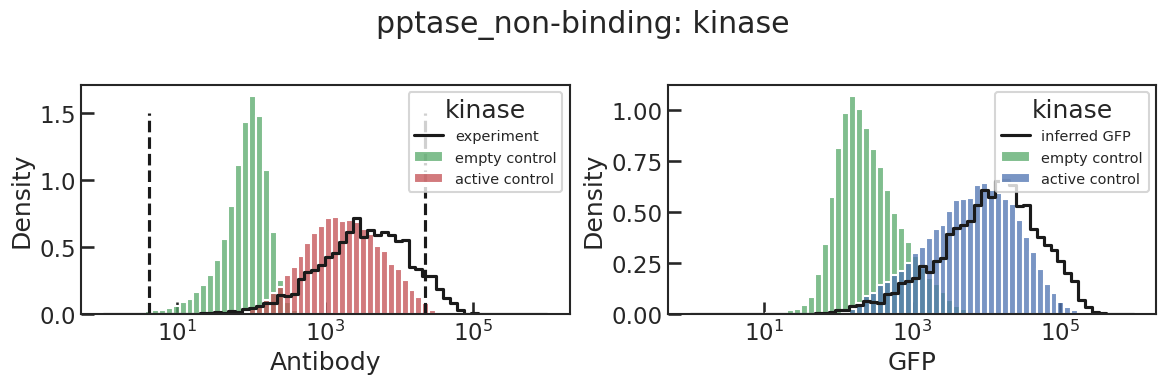

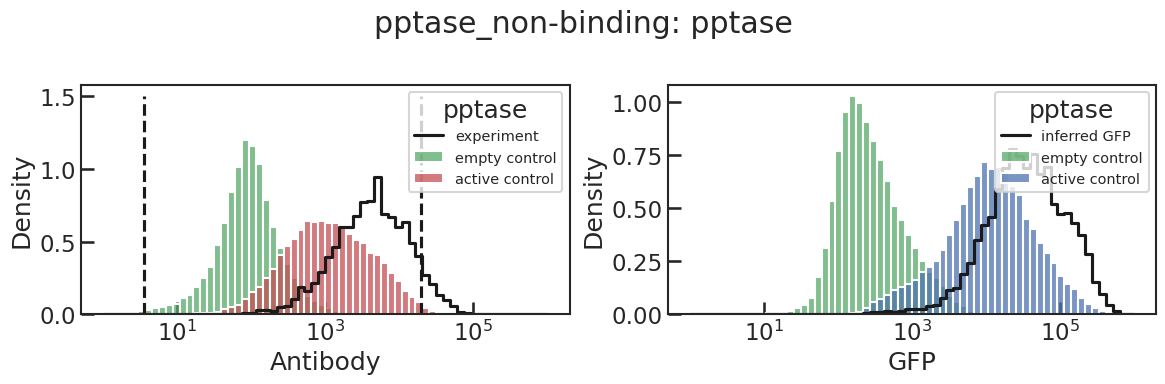

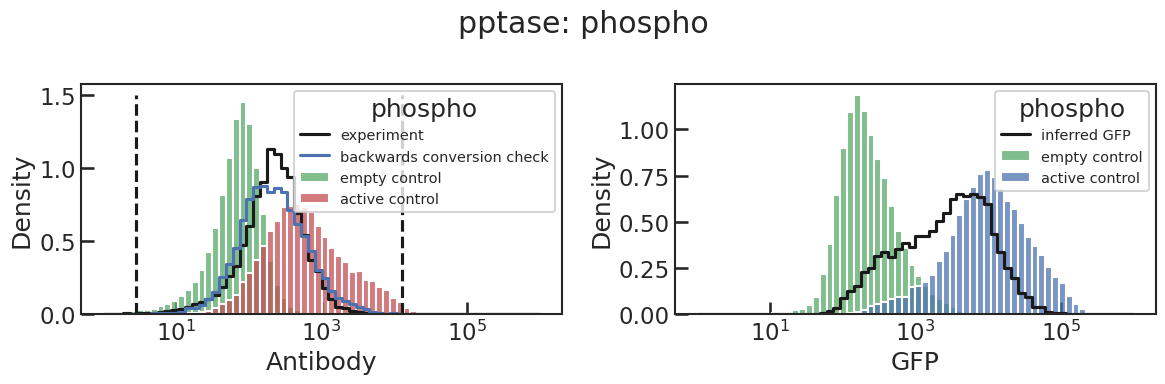

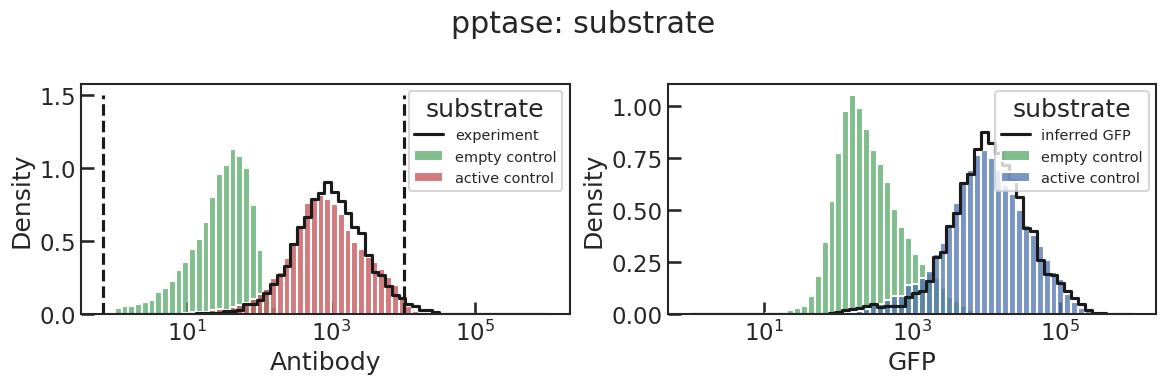

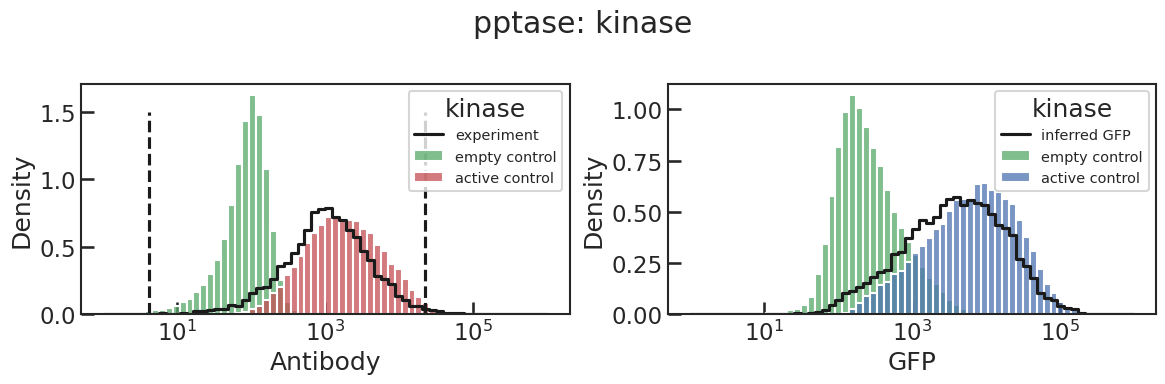

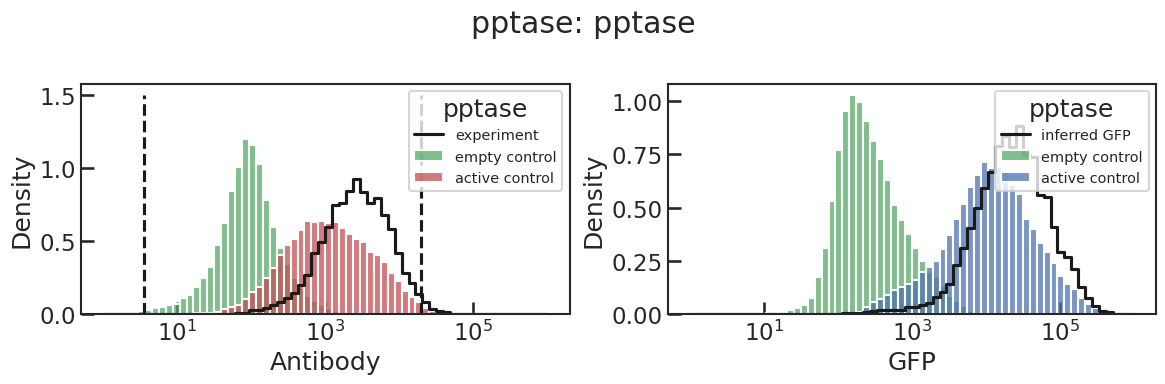

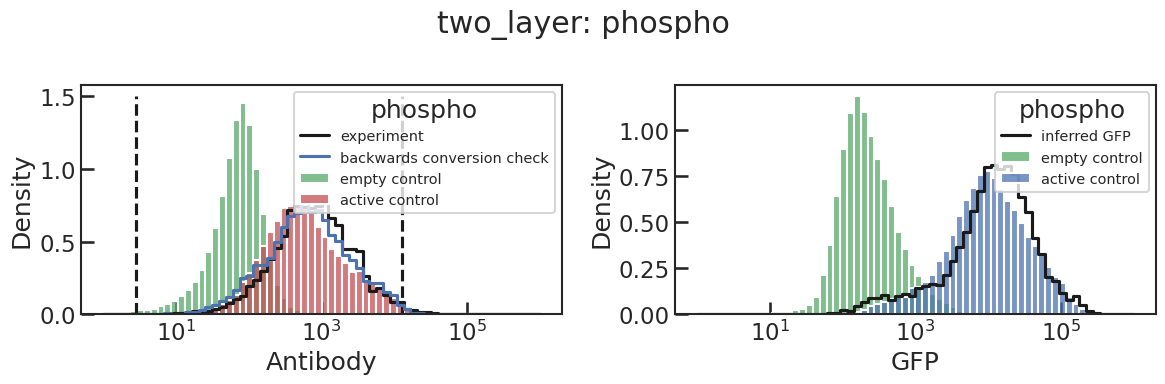

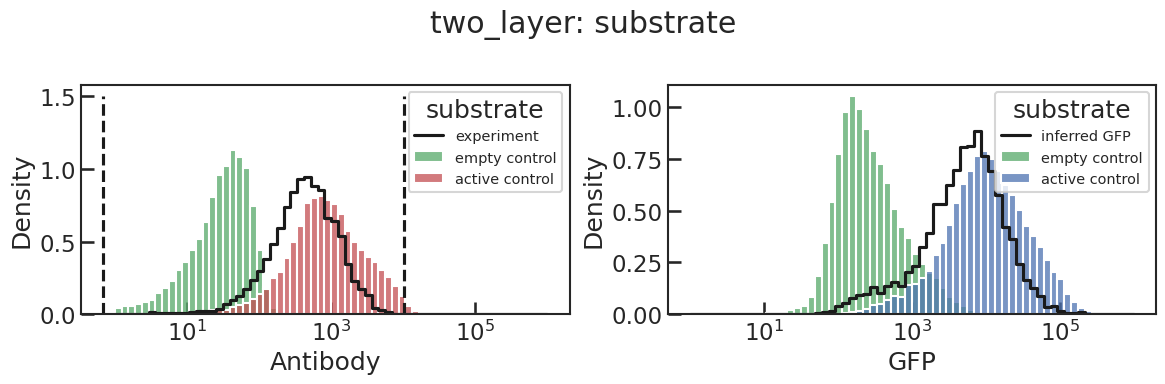

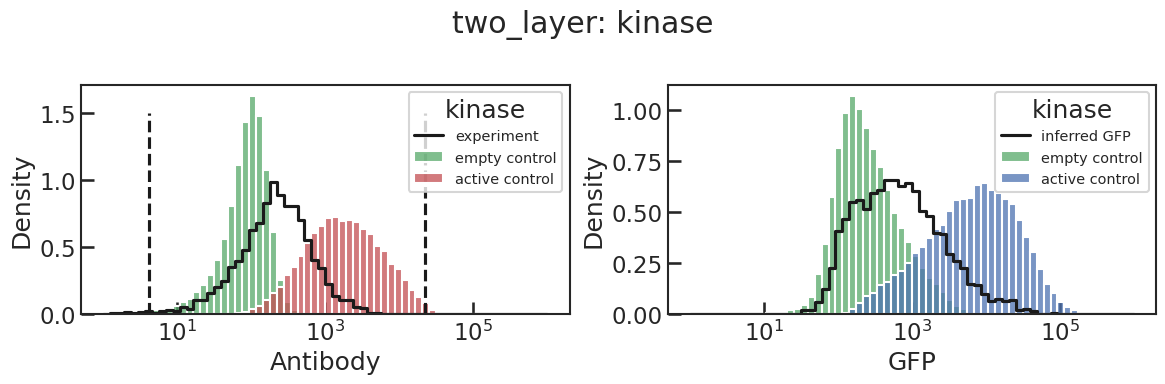

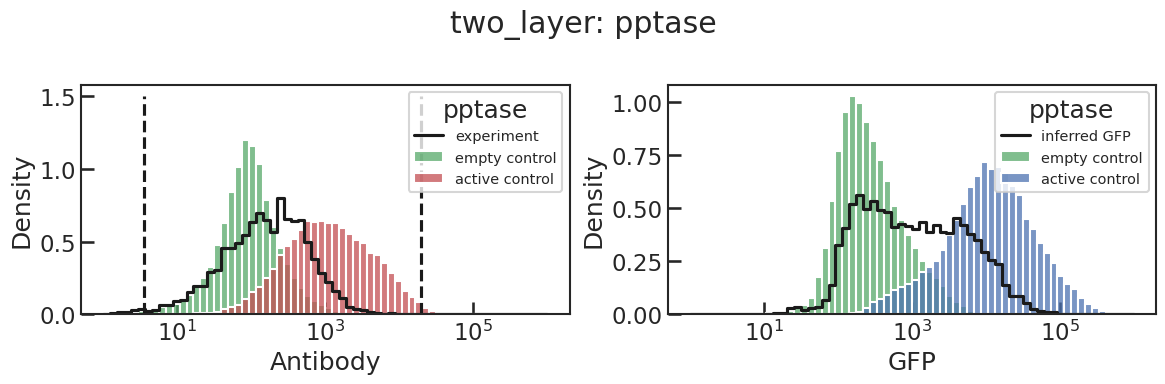

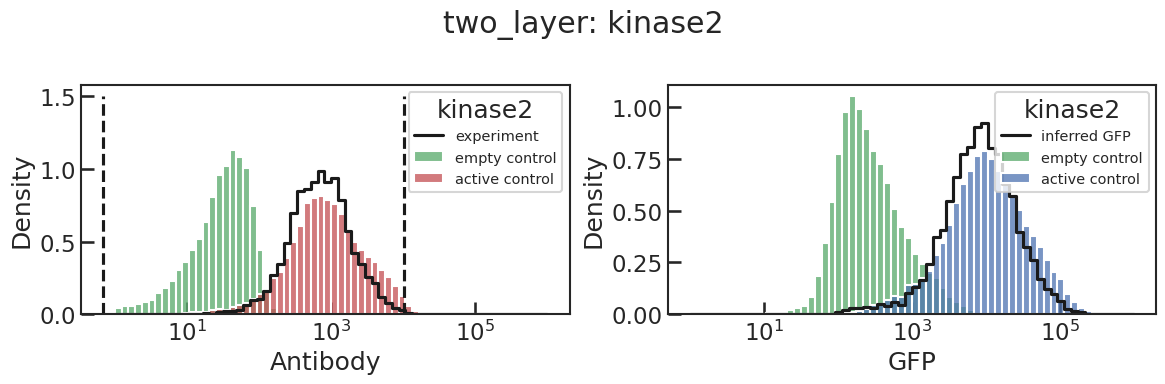

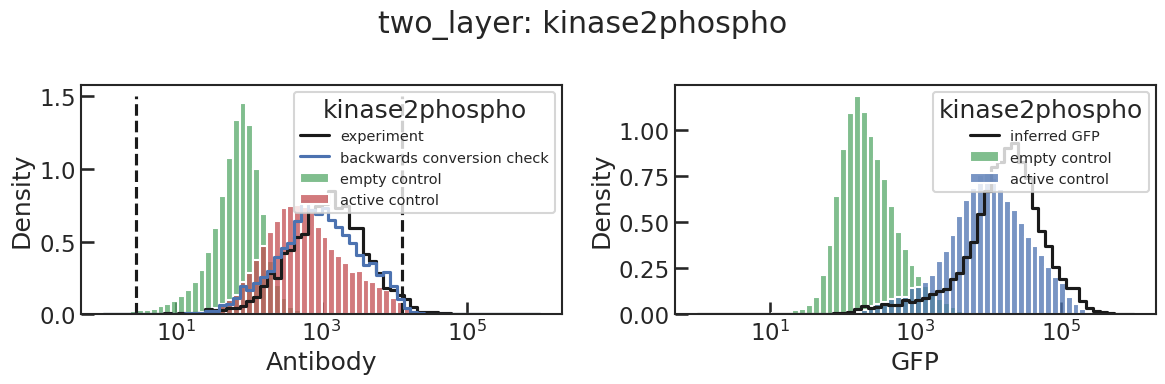

In [10]:

for exp_name, row in df_dataset_key.iterrows():
    
    df_tmp = df_data.query("exp_name==@exp_name").dropna()
    
    binrange = (0, 6)
        
    for c in components:
        
        # a weird way to check for nans or empty values
        if row[c+'_col'] != row[c+'_col']:
            continue
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 4), squeeze=False)
    
        fig.suptitle(exp_name+": " + c)
    
        ax = axes[0, 0]
        
#         ax.text(0.05, 0.95, c, va='top', ha='left', transform=ax.transAxes, fontsize='large')

        sns.histplot(noise_models[c]['empty_anti'].df['vals'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                     label='empty control', color='g', stat='density')
        sns.histplot(noise_models[c]['anti'].df['vals'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                     label='active control', color='r', stat='density')

        sns.histplot(df_data.loc[df_tmp.index, c+'_anti_exp'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                     label='experiment', element='step', fill=False, color='k', stat='density')

        ax.vlines([noise_models[c]['composite_anti2GFP'].low_cutoff, 
                   noise_models[c]['composite_anti2GFP'].high_cutoff], ymin=0, ymax=1.5, color='k', ls='--')
        
        if c == 'phospho' or c == 'kinase2phospho':
            GFP_infer = df_data.loc[df_tmp.index, c+'_GFP_infer']
            anti_check = noise_models[c]['composite_GFP2anti'].transform(GFP_infer)
        
            sns.histplot(anti_check, binrange=binrange, log_scale=True, bins=64, ax=ax, 
                     label='backwards conversion check', element='step', fill=False, color='b', stat='density')

        ax.set_xscale('log')
        ax.set_xlabel("Antibody")

        ax.legend(loc='upper right', fontsize='xx-small', title=c)



        ax = axes[0, 1]

        sns.histplot(noise_models[c]['empty_GFP'].df['vals'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                     label='empty control', color='g', stat='density')
        sns.histplot(noise_models[c]['GFP'].df['vals'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                     label='active control', color='b', stat='density')
        sns.histplot(df_tmp[c+"_GFP_infer"], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                     label='inferred GFP', element='step', fill=False, color='k', stat='density')


        ax.set_xscale('log')
        ax.set_xlabel("GFP")
        
        ax.legend(loc='upper right', fontsize='xx-small', title=c)
            


        plt.tight_layout()
        plt.show()
        
                

    

# Load prefit parameters

In [16]:
try:
    df_params = pd.read_csv("../data/"+label+"/model_params.csv", sep=',', engine='python')   
except:
    df_params = None

# df_params = None
    
display(df_params)

name       val   val_min   val_max
0      bg_phospho_rate -1.325694 -1.470259 -1.184675
1          kinase_dead -8.000000 -8.000000 -1.500816
2                  L+A -1.210884 -8.000000  0.433171
3            kinase_wt  1.172491  0.978995  1.377784
4   kinase_non-binding  6.796556  6.304530  7.553604
5                  375 -1.359053 -3.474527 -0.896750
6                  419 -0.467010 -0.806728 -0.123403
7                  E+A  4.841508 -8.000000  5.493434
8                  E+E  6.249143  5.807065  6.716143
9          pptase_dead -4.573486 -8.000000 -0.402977
10           pptase_wt  0.536489 -0.012217  0.876776
11  pptase_non-binding  0.064026 -1.580562  5.808094

# Fit all datasets simultaneously (except two layer)

In [9]:
df_params = fit.fit(df_dataset_key.query("model!='non-pplatable' and model!='two_layer'"), df_data, GFP_phospho_cutoff, df_params=df_params)

df_params = fit.calc_error(df_dataset_key.query("model!='non-pplatable' and model!='two_layer'"), df_data, GFP_phospho_cutoff, df_params=df_params)

display(df_params)

{}
{'bg_phospho_rate': 0, 'kinase_dead': 1, 'L+A': 2, 'kinase_wt': 3, 'kinase_non-binding': 4, '375': 5, '419': 6, 'E+A': 7, 'E+E': 8, 'pptase_dead': 9, 'pptase_wt': 10, 'pptase_non-binding': 11}
{'substrate_only': ['bg_phospho_rate'], 'kinase_dead': ['bg_phospho_rate', 'kinase_dead', 'L+A'], 'kinase_non-binding': ['bg_phospho_rate', 'kinase_wt', 'kinase_non-binding'], 'kinase_variant_375': ['bg_phospho_rate', '375', 'L+A'], 'kinase_variant_419': ['bg_phospho_rate', '419', 'L+A'], 'kinase_zipper_E+A': ['bg_phospho_rate', 'kinase_wt', 'E+A'], 'kinase_zipper_E+E': ['bg_phospho_rate', 'kinase_wt', 'E+E'], 'kinase_zipper_L+A': ['bg_phospho_rate', 'kinase_wt', 'L+A'], 'pptase_dead': ['bg_phospho_rate', 'kinase_wt', 'L+A', 'pptase_dead', 'L+A'], 'pptase_non-binding': ['bg_phospho_rate', 'kinase_wt', 'L+A', 'pptase_wt', 'pptase_non-binding'], 'pptase': ['bg_phospho_rate', 'kinase_wt', 'L+A', 'pptase_wt', 'L+A']}
[-2.0, -1.0, 3.0, -1.0, 3.0, -1.0, -1.0, 3.0, 3.0, -1.0, -1.0, 3.0]
[(-8, 1), (-8

name       val   val_min   val_max
0      bg_phospho_rate -1.325694 -1.470259 -1.184675
1          kinase_dead -8.000000 -8.000000 -1.500816
2                  L+A -1.210884 -8.000000  0.433171
3            kinase_wt  1.172491  0.978995  1.377784
4   kinase_non-binding  6.796556  6.304530  7.553604
5                  375 -1.359053 -3.474527 -0.896750
6                  419 -0.467010 -0.806728 -0.123403
7                  E+A  4.841508 -8.000000  5.493434
8                  E+E  6.249143  5.807065  6.716143
9          pptase_dead -4.573486 -8.000000 -0.402977
10           pptase_wt  0.536489 -0.012217  0.876776
11  pptase_non-binding  0.064026 -1.580562  5.808094

# Save model parameters


In [13]:
df_params.to_csv("../data/"+label+"/model_params.csv", sep=',', index=False)

# Fit substrate only data sets

In [ ]:
df_params = fit.fit(df_dataset_key.query("model=='substrate_only'"), df_data, GFP_phospho_cutoff, df_params=df_params)

df_params = fit.calc_error(df_dataset_key.query("model=='substrate_only'"), df_data, GFP_phospho_cutoff, df_params=df_params)

display(df_params)

# Save model parameters


In [9]:
df_params.to_csv("../data/"+label+"/model_params.csv", sep=',', index=False)

# Fit push data sets

In [ ]:
df_params = fit.fit(df_dataset_key.query("model=='push'"), df_data, GFP_phospho_cutoff, df_params=df_params)

df_params = fit.calc_error(df_dataset_key.query("model=='push'"), df_data, GFP_phospho_cutoff, df_params=df_params)

display(df_params)

# Save model parameters


In [11]:
df_params.to_csv("../data/"+label+"/model_params.csv", sep=',', index=False)

# Fit push-pull data sets

In [ ]:
df_params = fit.fit(df_dataset_key.query("model=='pushpull'"), df_data, GFP_phospho_cutoff, df_params=df_params)

df_params = fit.calc_error(df_dataset_key.query("model=='pushpull'"), df_data, GFP_phospho_cutoff, df_params=df_params)

display(df_params)

# Save model parameters


In [13]:
df_params.to_csv("../data/"+label+"/model_params.csv", sep=',', index=False)

# Fit two layer data sets

In [ ]:
df_params = fit.fit(df_dataset_key.query("model=='two_layer'"), df_data, GFP_phospho_cutoff, df_params=df_params)

df_params = fit.calc_error(df_dataset_key.query("model=='two_layer'"), df_data, GFP_phospho_cutoff, df_params=df_params)

display(df_params)

# Save model parameters


In [23]:
df_params.to_csv("../data/"+label+"/model_params.csv", sep=',', index=False)

# Calculate model predictions

In [19]:
prefit_params, param_to_index, dataset_to_params, x0, bounds = fit.setup_model_params(df_dataset_key, df_params=df_params)

x = np.zeros_like(x0)
for p in param_to_index:
    x[param_to_index[p]] = df_params.query("name==@p").iloc[0]['val']

args = (df_dataset_key, df_data, prefit_params, param_to_index, dataset_to_params, GFP_phospho_cutoff)

fit.predict(x, args, df_data)

display(df_data)

print(len(df_data))
print(len(df_data.dropna()))

kinase_anti_exp  substrate_anti_exp  \
exp_name       cell_index                                        
substrate_only 0                 79.178284         2212.525146   
               1                 86.252625         4954.513184   
               2                 10.157516         3487.114746   
               3                 96.854454          253.888428   
               4                118.221375          584.118408   
...                                    ...                 ...   
two_layer      8387             538.831848          509.163879   
               8388             502.579071          645.187561   
               8389             172.194412          680.760376   
               8390             129.300323          687.451172   
               8391             223.427887          396.494293   

                           phospho_anti_exp  pptase_anti_exp  \
exp_name       cell_index                                      
substrate_only 0                 133.354218     1.000000e-08   
               1                 112.124626     1.000000e-08   
               2                 119.673706     1.000000e-08   
               3                 100.082169     1.000000e-08   
               4                  39.466415     1.000000e-08   
...                                     ...              ...   
two_layer      8387              704.758423     7.326640e+01   
               8388             1412.649902     2.589982e+02   
               8389             2112.287354     2.860129e+02   
               8390             1222.891113     5.057090e+02   
               8391              746.775269     8.001365e+01   

                           kinase2_anti_exp  kinase2phospho_anti_exp  \
exp_name       cell_index                                              
substrate_only 0               1.000000e-08             1.000000e-08   
               1               1.000000e-08             1.000000e-08   
               2               1.000000e-08             1.000000e-08   
               3               1.000000e-08             1.000000e-08   
               4               1.000000e-08             1.000000e-08   
...                                     ...                      ...   
two_layer      8387            5.938093e+02             1.440575e+03   
               8388            9.887302e+02             2.151519e+03   
               8389            1.987362e+03             1.990649e+03   
               8390            8.492007e+02             1.806211e+03   
               8391            5.518015e+02             1.658656e+03   

                           phospho_GFP_infer  phospho_conc_infer  \
exp_name       cell_index                                          
substrate_only 0                  975.604414                 0.0   
               1                 1749.659563                 0.0   
               2                  336.290265                 0.0   
               3                   83.811712                 0.0   
               4                  310.791469                 0.0   
...                                      ...                 ...   
two_layer      8387              4883.559992                 0.0   
               8388             29577.775821                 0.0   
               8389             14195.129606                 0.0   
               8390             13589.528204                 0.0   
               8391              9974.198113                 0.0   

                           substrate_GFP_infer  substrate_conc_infer  \
exp_name       cell_index                                              
substrate_only 0                  21241.623933                   0.0   
               1                  35254.937260                   0.0   
               2                  21448.420977                   0.0   
               3                   2265.473029                   0.0   
               4                  11529.644980                   0.0   
...      

148135
148135


# Convert predicted GFP values to antibody values in the absence of GFP

In [21]:
df_data['phospho_anti_predict'] = 0.0
df_data['kinase2phospho_anti_predict'] = 0.0

for exp_name, row in df_dataset_key.iterrows():
    
    df_tmp = df_data.query("exp_name==@exp_name").dropna()

    df_data.loc[df_tmp.index, 'phospho_anti_predict'] = noise_models['phospho']['composite_GFP2anti'].transform(df_data.loc[df_tmp.index, 'phospho_GFP_predict'])

    if row['model'] == 'two_layer':
        df_data.loc[df_tmp.index, 'kinase2phospho_anti_predict'] = noise_models['kinase2phospho']['composite_GFP2anti'].transform(df_data.loc[df_tmp.index, 'kinase2phospho_GFP_predict'])

    
display(df_data)

/projectnb/biophys/jrocks/.conda/envs/default/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


kinase_anti_exp  substrate_anti_exp  \
exp_name       cell_index                                        
substrate_only 0                 79.178284         2212.525146   
               1                 86.252625         4954.513184   
               2                 10.157516         3487.114746   
               3                 96.854454          253.888428   
               4                118.221375          584.118408   
...                                    ...                 ...   
two_layer      8387             538.831848          509.163879   
               8388             502.579071          645.187561   
               8389             172.194412          680.760376   
               8390             129.300323          687.451172   
               8391             223.427887          396.494293   

                           phospho_anti_exp  pptase_anti_exp  \
exp_name       cell_index                                      
substrate_only 0                 133.354218     1.000000e-08   
               1                 112.124626     1.000000e-08   
               2                 119.673706     1.000000e-08   
               3                 100.082169     1.000000e-08   
               4                  39.466415     1.000000e-08   
...                                     ...              ...   
two_layer      8387              704.758423     7.326640e+01   
               8388             1412.649902     2.589982e+02   
               8389             2112.287354     2.860129e+02   
               8390             1222.891113     5.057090e+02   
               8391              746.775269     8.001365e+01   

                           kinase2_anti_exp  kinase2phospho_anti_exp  \
exp_name       cell_index                                              
substrate_only 0               1.000000e-08             1.000000e-08   
               1               1.000000e-08             1.000000e-08   
               2               1.000000e-08             1.000000e-08   
               3               1.000000e-08             1.000000e-08   
               4               1.000000e-08             1.000000e-08   
...                                     ...                      ...   
two_layer      8387            5.938093e+02             1.440575e+03   
               8388            9.887302e+02             2.151519e+03   
               8389            1.987362e+03             1.990649e+03   
               8390            8.492007e+02             1.806211e+03   
               8391            5.518015e+02             1.658656e+03   

                           phospho_GFP_infer  phospho_conc_infer  \
exp_name       cell_index                                          
substrate_only 0                  975.604414                 0.0   
               1                 1749.659563                 0.0   
               2                  336.290265                 0.0   
               3                   83.811712                 0.0   
               4                  310.791469                 0.0   
...                                      ...                 ...   
two_layer      8387              4883.559992                 0.0   
               8388             29577.775821                 0.0   
               8389             14195.129606                 0.0   
               8390             13589.528204                 0.0   
               8391              9974.198113                 0.0   

                           substrate_GFP_infer  substrate_conc_infer  ...  \
exp_name       cell_index                                             ...   
substrate_only 0                  21241.623933                   0.0  ...   
               1                  35254.937260                   0.0  ...   
               2                  21448.420977                   0.0  ...   
               3                   2265.473029                   0.0  ...   
               4                  11529.644980     

# Save predictions

In [22]:
df_data.to_csv("../data/"+label+"/model_predictions.csv", sep=',')